In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')

# Set visualization style for better-looking plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Confirm successful import
print("=" * 70)
print("✅ ALL LIBRARIES IMPORTED SUCCESSFULLY!")
print("=" * 70)
print("\nLibraries loaded:")
print("  • NumPy version:", np.__version__)
print("  • Pandas version:", pd.__version__)
print("  • Scikit-learn: Ready for PCA and K-Means")
print("  • Matplotlib & Seaborn: Ready for visualizations")
print("\n" + "=" * 70)

✅ ALL LIBRARIES IMPORTED SUCCESSFULLY!

Libraries loaded:
  • NumPy version: 2.1.3
  • Pandas version: 2.2.3
  • Scikit-learn: Ready for PCA and K-Means
  • Matplotlib & Seaborn: Ready for visualizations



In [5]:
class SimplePCA:
    """
    Principal Component Analysis for DeFi Portfolio Analysis
    
    This class wraps sklearn's PCA with helpful methods for:
    - Fitting PCA to DeFi data
    - Transforming data to PC space
    - Analyzing variance explained
    - Visualizing results
    - Interpreting component loadings
    """
    
    def __init__(self, n_components=None):
        """
        Initialize PCA
        
        Parameters:
        -----------
        n_components : int or None
            Number of components to keep
            - None = keep all components
            - int = keep specific number (e.g., 5)
            - Tip: Start with None to see all, then choose optimal number
        """
        self.n_components = n_components
        self.scaler = StandardScaler()  # For standardizing features
        self.pca = None  # Will hold the fitted PCA model
        self.feature_names = None  # To remember original feature names
        
    def fit(self, X, feature_names=None):
        """
        Fit PCA model to data
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Data matrix (e.g., 50 tokens × 8 features)
        feature_names : list of str, optional
            Names of features for better interpretation
        
        Returns:
        --------
        self : object
            Returns self for method chaining
        """
        # Step 1: Standardize features (VERY IMPORTANT!)
        # This ensures all features have mean=0 and std=1
        X_scaled = self.scaler.fit_transform(X)
        
        # Step 2: Fit PCA
        self.pca = PCA(n_components=self.n_components)
        self.pca.fit(X_scaled)
        
        # Step 3: Save feature names for later use
        self.feature_names = feature_names
        
        # Print summary
        print(f"\n✅ PCA fitted successfully!")
        print(f"   Components: {self.pca.n_components_}")
        print(f"   Total variance explained: {self.pca.explained_variance_ratio_.sum():.2%}")
        
        return self
    
    def transform(self, X):
        """
        Transform data to principal component space
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Data to transform
        
        Returns:
        --------
        X_transformed : array, shape (n_samples, n_components)
            Data in PC space
        """
        X_scaled = self.scaler.transform(X)
        return self.pca.transform(X_scaled)
    
    def fit_transform(self, X, feature_names=None):
        """
        Fit PCA and transform data in one step
        
        This is a convenience method that combines fit() and transform()
        """
        self.fit(X, feature_names)
        return self.transform(X)
    
    def inverse_transform(self, X_pca):
        """
        Reconstruct original features from principal components
        
        Useful for understanding what PCs represent
        """
        X_scaled = self.pca.inverse_transform(X_pca)
        return self.scaler.inverse_transform(X_scaled)
    
    def get_variance_summary(self):
        """
        Get detailed variance statistics for each component
        
        Returns:
        --------
        DataFrame with columns:
        - PC: Component name (PC1, PC2, ...)
        - Variance_Explained: Proportion of variance (0 to 1)
        - Cumulative_Variance: Running total of variance
        - Eigenvalue: The actual eigenvalue (variance in that direction)
        """
        var_exp = self.pca.explained_variance_ratio_
        cum_var = np.cumsum(var_exp)
        
        df = pd.DataFrame({
            'PC': [f'PC{i+1}' for i in range(len(var_exp))],
            'Variance_Explained': var_exp,
            'Cumulative_Variance': cum_var,
            'Eigenvalue': self.pca.explained_variance_
        })
        
        return df
    
    def get_loadings(self):
        """
        Get feature loadings (how features relate to PCs)
        
        Loadings tell us:
        - Which features contribute most to each PC
        - Direction of relationship (positive or negative)
        
        Returns:
        --------
        DataFrame with features as rows, PCs as columns
        
        Interpretation:
        - High positive loading: Feature increases with PC
        - High negative loading: Feature decreases with PC  
        - Near-zero loading: Feature unrelated to PC
        """
        loadings = pd.DataFrame(
            self.pca.components_.T,
            columns=[f'PC{i+1}' for i in range(self.pca.n_components_)],
            index=self.feature_names if self.feature_names else range(self.pca.n_components_)
        )
        return loadings
    
    def plot_scree(self, figsize=(14, 5)):
        """
        Create scree plot to help choose optimal number of components
        
        The scree plot shows:
        - Left: Variance per component (look for "elbow")
        - Right: Cumulative variance (aim for 80-90%)
        """
        var_summary = self.get_variance_summary()
        
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        
        # Left plot: Scree Plot
        axes[0].bar(var_summary['PC'], var_summary['Variance_Explained'], 
                    alpha=0.7, color='steelblue')
        axes[0].plot(var_summary['PC'], var_summary['Variance_Explained'], 
                     'ro-', linewidth=2, markersize=8)
        axes[0].set_xlabel('Principal Component', fontsize=12)
        axes[0].set_ylabel('Variance Explained', fontsize=12)
        axes[0].set_title('Scree Plot\n(Look for the "elbow")', 
                         fontsize=13, fontweight='bold')
        axes[0].grid(True, alpha=0.3)
        axes[0].tick_params(axis='x', rotation=45)
        
        # Right plot: Cumulative Variance
        axes[1].plot(var_summary['PC'], var_summary['Cumulative_Variance'], 
                     'bo-', linewidth=2, markersize=8)
        axes[1].axhline(y=0.80, color='green', linestyle='--', 
                        linewidth=2, label='80% threshold')
        axes[1].axhline(y=0.90, color='orange', linestyle='--', 
                        linewidth=2, label='90% threshold')
        axes[1].set_xlabel('Number of Components', fontsize=12)
        axes[1].set_ylabel('Cumulative Variance Explained', fontsize=12)
        axes[1].set_title('Cumulative Variance Explained', 
                         fontsize=13, fontweight='bold')
        axes[1].legend(fontsize=10)
        axes[1].grid(True, alpha=0.3)
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].set_ylim([0, 1.05])
        
        plt.tight_layout()
        return fig
    
    def plot_loadings(self, n_components=3, n_top_features=10, figsize=(15, 5)):
        """
        Visualize feature loadings for top components
        
        Shows which features are most important for each PC
        
        Parameters:
        -----------
        n_components : int
            Number of PCs to display (default: 3)
        n_top_features : int
            How many features to show per PC (default: 10)
        """
        loadings = self.get_loadings()
        n_components = min(n_components, loadings.shape[1])
        
        fig, axes = plt.subplots(1, n_components, figsize=figsize)
        if n_components == 1:
            axes = [axes]
        
        for i in range(n_components):
            pc_col = f'PC{i+1}'
            
            # Get top features by absolute loading
            top_features = loadings[pc_col].abs().nlargest(n_top_features)
            sorted_loadings = loadings.loc[top_features.index, pc_col].sort_values()
            
            # Color code: red=negative, green=positive
            colors = ['red' if x < 0 else 'green' for x in sorted_loadings.values]
            
            axes[i].barh(range(len(sorted_loadings)), sorted_loadings.values, 
                        color=colors, alpha=0.7)
            axes[i].set_yticks(range(len(sorted_loadings)))
            axes[i].set_yticklabels(sorted_loadings.index, fontsize=9)
            axes[i].set_xlabel('Loading', fontsize=11)
            axes[i].set_title(f'{pc_col}\n({self.pca.explained_variance_ratio_[i]:.1%} variance)', 
                            fontsize=12, fontweight='bold')
            axes[i].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
            axes[i].grid(True, alpha=0.3, axis='x')
        
        plt.tight_layout()
        return fig

print("=" * 70)
print("✅ SimplePCA class created successfully!")
print("=" * 70)
print("\nAvailable methods:")
print("  • fit(X, feature_names) - Fit PCA to data")
print("  • transform(X) - Transform data to PC space")
print("  • fit_transform(X, feature_names) - Fit and transform in one step")
print("  • get_variance_summary() - Get variance statistics")
print("  • get_loadings() - Get feature loadings")
print("  • plot_scree() - Visualize variance explained")
print("  • plot_loadings() - Visualize feature importance")
#print("\n👉 Next: We'll generate some synthetic DeFi data to practice with")
print("=" * 70)

✅ SimplePCA class created successfully!

Available methods:
  • fit(X, feature_names) - Fit PCA to data
  • transform(X) - Transform data to PC space
  • fit_transform(X, feature_names) - Fit and transform in one step
  • get_variance_summary() - Get variance statistics
  • get_loadings() - Get feature loadings
  • plot_scree() - Visualize variance explained
  • plot_loadings() - Visualize feature importance


In [11]:
# ===============================================================
# DATA COLLECTION — CoinGecko API (Auto-Retry, >=30 Assets)
# ===============================================================
import pandas as pd
import numpy as np
import requests
import time
from tqdm.auto import tqdm

# --- Ρυθμίσεις ---
TARGET_ASSETS = 30        # θέλουμε τουλάχιστον 30 assets
LOOKBACK_DAYS = 210       # ~7 μήνες δεδομένων
VS_CURRENCY = "usd"
CATEGORY = "decentralized-finance-defi"
COINGECKO_BASE = "https://api.coingecko.com/api/v3"

# --- Βοηθητικές συναρτήσεις ---
def cg_get(path, params=None, max_retries=3, sleep_sec=10):
    """API call στο CoinGecko με retry & rate-limit control"""
    for attempt in range(max_retries):
        try:
            r = requests.get(f"{COINGECKO_BASE}{path}", params=params, timeout=30)
            if r.status_code == 429:
                print("⏳ Rate limit reached — waiting 20s...")
                time.sleep(20)
                continue
            if not r.ok:
                print(f"⚠️ CoinGecko error {r.status_code}: {r.text[:150]}")
                return None
            return r.json()
        except requests.exceptions.RequestException as e:
            print(f"⚠️ Connection error: {e} — retrying...")
            time.sleep(sleep_sec)
    print("❌ Failed after retries.")
    return None

def get_top_assets_by_category(category, n, vs_currency="usd"):
    """Λήψη των top n assets από μια κατηγορία (π.χ. DeFi)"""
    params = {
        "vs_currency": vs_currency,
        "order": "market_cap_desc",
        "per_page": min(n, 250),
        "page": 1,
        "sparkline": "false",
        "category": category
    }
    data = cg_get("/coins/markets", params=params)
    if not data:
        print("⚠️ Category failed — using global top coins instead.")
        params.pop("category", None)
        data = cg_get("/coins/markets", params=params)
    df = pd.DataFrame(data)
    return df[["id", "symbol", "name", "market_cap"]].head(n).reset_index(drop=True)

def get_market_chart(coin_id, vs_currency="usd", days=180):
    """Κατεβάζει ιστορικά δεδομένα (price, market cap, total volume)"""
    data = cg_get(f"/coins/{coin_id}/market_chart",
                  params={"vs_currency": vs_currency, "days": days})
    if data is None:
        return None

    out = {}
    for key in ["prices", "market_caps", "total_volumes"]:
        arr = data.get(key, [])
        if len(arr) == 0:
            print(f"⚠️ Missing field '{key}' for {coin_id}")
            out[key] = pd.DataFrame(columns=["date", key[:-1]])
            continue
        df = pd.DataFrame(arr, columns=["ts_ms", key[:-1]])
        df["date"] = pd.to_datetime(df["ts_ms"], unit="ms").dt.tz_localize(None).dt.floor("D")
        out[key] = df[["date", key[:-1]]].drop_duplicates("date").set_index("date").sort_index()
    return out


# ===============================================================
# Λήψη Λίστας Assets
# ===============================================================
top_df = get_top_assets_by_category(CATEGORY, 50, VS_CURRENCY)
print(f"✅ Λήφθηκαν {len(top_df)} DeFi assets από το CoinGecko.")
display(top_df.head())

# ===============================================================
# Επαναληπτική Λήψη (μέχρι να έχουμε >=30 assets)
# ===============================================================
MAX_ROUNDS = 5
successful_assets = []
round_num = 0

prices, volumes, mkt_caps = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

while len(successful_assets) < TARGET_ASSETS and round_num < MAX_ROUNDS:
    round_num += 1
    print(f"\n🔁 Γύρος {round_num}: Κατεβάζουμε δεδομένα... "
          f"(έχουμε {len(successful_assets)} assets μέχρι τώρα)")
    
    missing_assets = [cid for cid in top_df["id"] if cid not in successful_assets]
    if not missing_assets:
        break

    for cid in tqdm(missing_assets):
        try:
            time.sleep(3)  # rate limit control
            mc = get_market_chart(cid, VS_CURRENCY, LOOKBACK_DAYS)
            if mc is None or mc["prices"].empty:
                print(f"⚠️ Χωρίς δεδομένα για {cid}")
                continue

            prices[cid]   = mc["prices"]["price"]
            volumes[cid]  = mc["total_volumes"]["total_volume"]
            mkt_caps[cid] = mc["market_caps"]["market_cap"]
            successful_assets.append(cid)
        except Exception as e:
            print(f"❌ Σφάλμα στο asset {cid}: {e}")
            time.sleep(4)
            continue

    print(f"✅ Ολοκληρώθηκε ο γύρος {round_num}: "
          f"{len(successful_assets)} assets συνολικά κατέβηκαν επιτυχώς.\n")

# ===============================================================
# Καθαρισμός & Επαναδεικτοδότηση
# ===============================================================
if len(successful_assets) < TARGET_ASSETS:
    print(f"⚠️ Τελικά κατέβηκαν {len(successful_assets)} assets (<{TARGET_ASSETS}).")

if not prices.empty:
    full_idx = pd.date_range(prices.index.min(), prices.index.max(), freq="D")
    prices   = prices.reindex(full_idx).ffill().bfill()
    volumes  = volumes.reindex_like(prices).fillna(0)
    mkt_caps = mkt_caps.reindex_like(prices).ffill().bfill()
else:
    raise RuntimeError("❌ Δεν κατέβηκαν καθόλου δεδομένα από το CoinGecko.")

print("\n✅ Διαστάσεις των δεδομένων:")
print("Prices:", prices.shape, "| Volumes:", volumes.shape, "| Market Caps:", mkt_caps.shape)

# ===============================================================
# Υπολογισμός χαρακτηριστικών (Features)
# ===============================================================
def compute_features(prices_df, volumes_df, mkt_df):
    """Υπολογισμός χαρακτηριστικών"""
    rets = prices_df.pct_change().dropna(how="all")
    ann_vol = rets.std(skipna=True) * np.sqrt(365)
    feats = pd.DataFrame({
        "price": prices_df.ffill().iloc[-1],
        "avg_volume": volumes_df.replace(0, np.nan).ffill().tail(30).mean(),
        "market_cap": mkt_df.ffill().iloc[-1],
        "volatility_ann": ann_vol
    })
    feats["avg_volume_log"] = np.log1p(feats["avg_volume"])
    feats["market_cap_log"] = np.log1p(feats["market_cap"])
    return feats

features = compute_features(prices, volumes, mkt_caps)

print("\n✅ Feature matrix (preview):")
display(features.head(10))

# ===============================================================
# Προαιρετικά: Αποθήκευση δεδομένων
# ===============================================================
prices.to_csv("prices_defi.csv")
volumes.to_csv("volumes_defi.csv")
mkt_caps.to_csv("mkt_caps_defi.csv")
features.to_csv("features_defi.csv")
print("\n💾 Τα δεδομένα αποθηκεύτηκαν επιτυχώς.")


✅ Λήφθηκαν 50 DeFi assets από το CoinGecko.


,id,symbol,name,market_cap
0,staked-ether,steth,Lido Staked Ether,33544177399
1,wrapped-steth,wsteth,Wrapped stETH,15893168173
2,hyperliquid,hype,Hyperliquid,13066829934
3,chainlink,link,Chainlink,12511803809
4,dai,dai,Dai,4673270252



🔁 Γύρος 1: Κατεβάζουμε δεδομένα... (έχουμε 0 assets μέχρι τώρα)


  0%|          | 0/50 [00:00<?, ?it/s]

⏳ Rate limit reached — waiting 20s...
⏳ Rate limit reached — waiting 20s...
⏳ Rate limit reached — waiting 20s...
❌ Failed after retries.
⚠️ Χωρίς δεδομένα για uniswap
⏳ Rate limit reached — waiting 20s...
⏳ Rate limit reached — waiting 20s...
⏳ Rate limit reached — waiting 20s...
❌ Failed after retries.
⚠️ Χωρίς δεδομένα για aster-2
⏳ Rate limit reached — waiting 20s...
⏳ Rate limit reached — waiting 20s...
⏳ Rate limit reached — waiting 20s...
❌ Failed after retries.
⚠️ Χωρίς δεδομένα για sei-network
⏳ Rate limit reached — waiting 20s...
⏳ Rate limit reached — waiting 20s...
⏳ Rate limit reached — waiting 20s...
❌ Failed after retries.
⚠️ Χωρίς δεδομένα για msol
⏳ Rate limit reached — waiting 20s...
⏳ Rate limit reached — waiting 20s...
⏳ Rate limit reached — waiting 20s...
❌ Failed after retries.
⚠️ Χωρίς δεδομένα για ether-fi
⏳ Rate limit reached — waiting 20s...
⏳ Rate limit reached — waiting 20s...
⏳ Rate limit reached — waiting 20s...
❌ Failed after retries.
⚠️ Χωρίς δεδομένα γι

,price,avg_volume,market_cap,volatility_ann,avg_volume_log,market_cap_log
staked-ether,3895.744336,6.017016e+07,3.345385e+10,0.770827,17.912687,24.233433
wrapped-steth,4744.855251,2.561255e+07,1.586797e+10,0.770936,17.058593,23.487568
hyperliquid,47.935208,6.195753e+08,1.294979e+10,0.995632,20.244545,23.284346
chainlink,18.082754,1.070279e+09,1.259523e+10,0.892337,20.791185,23.256584
dai,0.999772,1.089253e+08,4.933362e+09,0.010559,18.506173,22.319287
aave,227.474313,4.121445e+08,3.471154e+09,0.897218,19.836885,21.967753
ethena,0.442727,4.571172e+08,3.162489e+09,1.357960,19.940450,21.874625
ondo-finance,0.728079,1.845676e+08,2.299996e+09,0.865592,19.033527,21.556173
jupiter-perpetuals-liquidity-provider-token,5.509143,7.531263e+07,2.262347e+09,0.370983,18.137158,21.539669
pump-fun,0.005248,4.167409e+08,1.859008e+09,1.231386,19.847975,21.343309



💾 Τα δεδομένα αποθηκεύτηκαν επιτυχώς.


In [14]:
# --- Data Cleaning Step before PCA ---
print("\n🧹 Cleaning missing values before PCA...")

nan_summary = defi_data.isna().sum()
print("Missing values per feature:")
display(nan_summary)

# Επιλογή: drop ή impute
defi_data = defi_data.dropna()  # ή .fillna(defi_data.mean())

print(f"\n✅ Final shape for PCA: {defi_data.shape}")
print(f"Total missing values: {defi_data.isna().sum().sum()}")



🧹 Cleaning missing values before PCA...
Missing values per feature:


price             0
avg_volume        1
market_cap        0
volatility_ann    0
avg_volume_log    1
market_cap_log    0
dtype: int64


✅ Final shape for PCA: (41, 6)
Total missing values: 0


FITTING PCA TO DeFi PORTFOLIO DATA

🧮 Initial feature matrix shape: (42, 6)


,price,avg_volume,market_cap,volatility_ann,avg_volume_log,market_cap_log
staked-ether,3895.744336,6.017016e+07,3.345385e+10,0.770827,17.912687,24.233433
wrapped-steth,4744.855251,2.561255e+07,1.586797e+10,0.770936,17.058593,23.487568
hyperliquid,47.935208,6.195753e+08,1.294979e+10,0.995632,20.244545,23.284346
chainlink,18.082754,1.070279e+09,1.259523e+10,0.892337,20.791185,23.256584
dai,0.999772,1.089253e+08,4.933362e+09,0.010559,18.506173,22.319287



🧹 Cleaning missing values before PCA...
Missing values per feature:


price             0
avg_volume        1
market_cap        0
volatility_ann    0
avg_volume_log    1
market_cap_log    0
dtype: int64


✅ Final shape for PCA: (41, 6)
Total missing values: 0

🔧 Initializing PCA model...
   Setting n_components=5 (ξεκινάμε με 5 components για ανάλυση)

⚙️  Fitting PCA and transforming data...

✅ PCA fitted successfully!
   Components: 5
   Total variance explained: 98.06%

TRANSFORMATION COMPLETE!

📊 Dimensionality Reduction:
   Original shape: 41 tokens × 6 features
   Reduced shape:  41 tokens × 5 components
   Reduction: 6 → 5 dimensions
   Space savings: 16.7% fewer dimensions!

📈 Variance Explained by Each Component:


,PC,Variance_Explained,Cumulative_Variance,Eigenvalue
0,PC1,0.4251,0.4251,2.6145
1,PC2,0.2165,0.6416,1.3316
2,PC3,0.1609,0.8025,0.9894
3,PC4,0.1329,0.9354,0.8173
4,PC5,0.0451,0.9806,0.2776



🔍 Key Insights:
   • PC1 captures 42.5% of total variance
   • PC1 + PC2 capture 64.2%
   • First 3 PCs capture 80.3%
   • All 5 PCs capture 98.1% of total variance

✅ Excellent! 98.1% variance retained with just 5 components.

📉 Generating PCA visualizations...


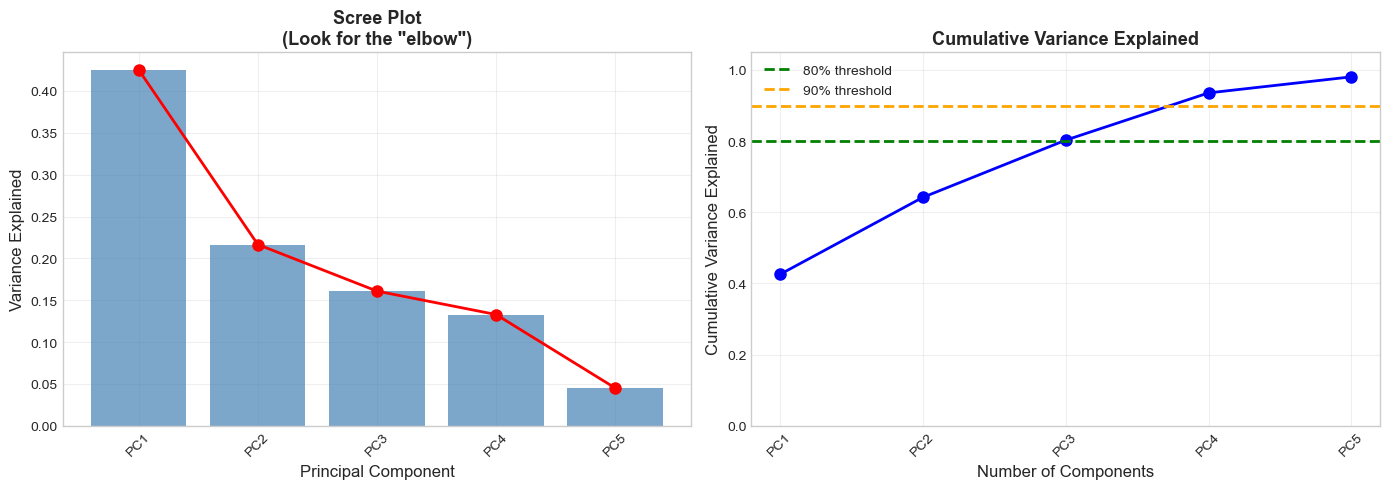

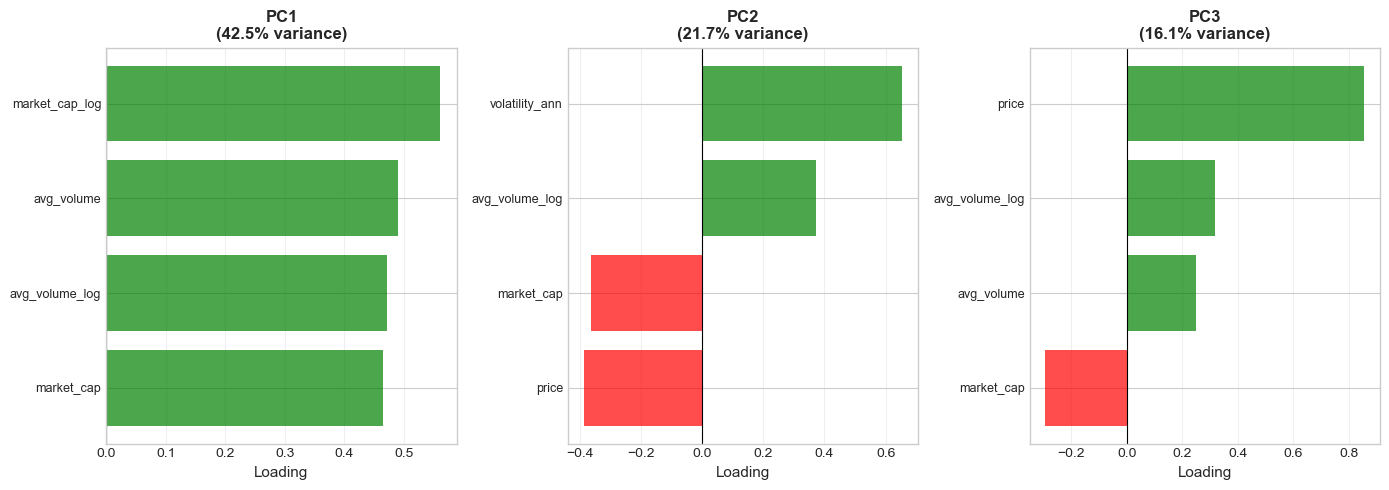


📋 Sample of Transformed Data (PC space):


,PC1,PC2,PC3,PC4,PC5
staked-ether,3.991,-2.873,-1.915,2.543,-0.314
wrapped-steth,1.957,-1.885,-1.109,1.319,-0.298
hyperliquid,3.847,0.073,0.076,-0.031,0.498
chainlink,4.994,0.756,0.719,-0.875,1.797
dai,1.172,-0.976,-0.311,-0.589,-0.706



💡 Interpretation:
   • Κάθε γραμμή = ένα token
   • Κάθε στήλη = ένας principal component
   • Οι τιμές δείχνουν το 'score' κάθε token στη συγκεκριμένη συνιστώσα
   • Μεγάλη θετική/αρνητική τιμή = ισχυρή επιρροή από αυτόν τον παράγοντα

✅ PCA fitting complete! Data successfully transformed.


In [16]:
# ===============================================================
# 1.2 PRINCIPAL COMPONENT ANALYSIS (PCA)
# ===============================================================
print("=" * 70)
print("FITTING PCA TO DeFi PORTFOLIO DATA")
print("=" * 70)

# Χρησιμοποιούμε το feature matrix από το βήμα 1.1
defi_data = features.copy()   # ή features_clean αν έχεις κάνει filtering
print(f"\n🧮 Initial feature matrix shape: {defi_data.shape}")
display(defi_data.head())

# ===============================================================
# --- Data Cleaning Step before PCA ---
# ===============================================================
print("\n🧹 Cleaning missing values before PCA...")

nan_summary = defi_data.isna().sum()
print("Missing values per feature:")
display(nan_summary)

# Αν υπάρχουν NaN, αφαιρούμε τις γραμμές (assets) που τα περιέχουν
defi_data = defi_data.dropna()   # ή εναλλακτικά: defi_data = defi_data.fillna(defi_data.mean())

print(f"\n✅ Final shape for PCA: {defi_data.shape}")
print(f"Total missing values: {defi_data.isna().sum().sum()}")

# ===============================================================
# --- Fit PCA Model ---
# ===============================================================
print("\n🔧 Initializing PCA model...")
print("   Setting n_components=5 (ξεκινάμε με 5 components για ανάλυση)")

pca_model = SimplePCA(n_components=5)

print("\n⚙️  Fitting PCA and transforming data...")
X_pca = pca_model.fit_transform(
    defi_data.values,
    feature_names=defi_data.columns.tolist()
)

print("\n" + "=" * 70)
print("TRANSFORMATION COMPLETE!")
print("=" * 70)

# ===============================================================
# --- PCA Summary ---
# ===============================================================
print(f"\n📊 Dimensionality Reduction:")
print(f"   Original shape: {defi_data.shape[0]} tokens × {defi_data.shape[1]} features")
print(f"   Reduced shape:  {X_pca.shape[0]} tokens × {X_pca.shape[1]} components")
print(f"   Reduction: {defi_data.shape[1]} → {X_pca.shape[1]} dimensions")
print(f"   Space savings: {(1 - X_pca.shape[1]/defi_data.shape[1])*100:.1f}% fewer dimensions!")

variance_summary = pca_model.get_variance_summary()
print("\n📈 Variance Explained by Each Component:")
display(variance_summary.round(4))

# --- Insights ---
total_var = variance_summary['Cumulative_Variance'].iloc[-1]
pc1_var   = variance_summary['Variance_Explained'].iloc[0]
pc2_var   = variance_summary['Variance_Explained'].iloc[1]
pc3_var   = variance_summary['Variance_Explained'].iloc[2]

print("\n🔍 Key Insights:")
print(f"   • PC1 captures {pc1_var:.1%} of total variance")
print(f"   • PC1 + PC2 capture {variance_summary['Cumulative_Variance'].iloc[1]:.1%}")
print(f"   • First 3 PCs capture {variance_summary['Cumulative_Variance'].iloc[2]:.1%}")
print(f"   • All 5 PCs capture {total_var:.1%} of total variance")

if total_var >= 0.90:
    print(f"\n✅ Excellent! {total_var:.1%} variance retained with just 5 components.")
elif total_var >= 0.80:
    print(f"\n✅ Good! {total_var:.1%} variance retained — acceptable for most analyses.")
else:
    print(f"\n⚠️  Only {total_var:.1%} variance retained — consider increasing components.")

# ===============================================================
# --- Visualizations ---
# ===============================================================
print("\n📉 Generating PCA visualizations...")
fig1 = pca_model.plot_scree(figsize=(14,5))
plt.show()

fig2 = pca_model.plot_loadings(n_components=3, n_top_features=4, figsize=(14,5))
plt.show()

# ===============================================================
# --- Transformed Data (Preview) ---
# ===============================================================
X_pca_df = pd.DataFrame(
    X_pca,
    columns=[f'PC{i+1}' for i in range(X_pca.shape[1])],
    index=defi_data.index
)

print("\n📋 Sample of Transformed Data (PC space):")
display(X_pca_df.head(5).round(3))

print("\n💡 Interpretation:")
print("   • Κάθε γραμμή = ένα token")
print("   • Κάθε στήλη = ένας principal component")
print("   • Οι τιμές δείχνουν το 'score' κάθε token στη συγκεκριμένη συνιστώσα")
print("   • Μεγάλη θετική/αρνητική τιμή = ισχυρή επιρροή από αυτόν τον παράγοντα")

print("\n" + "=" * 70)
print("✅ PCA fitting complete! Data successfully transformed.")
print("=" * 70)


VISUALIZING VARIANCE EXPLAINED - SCREE PLOT

📊 Creating scree plot to determine optimal number of components...
   This will help us decide: 'How many PCs should we keep?'



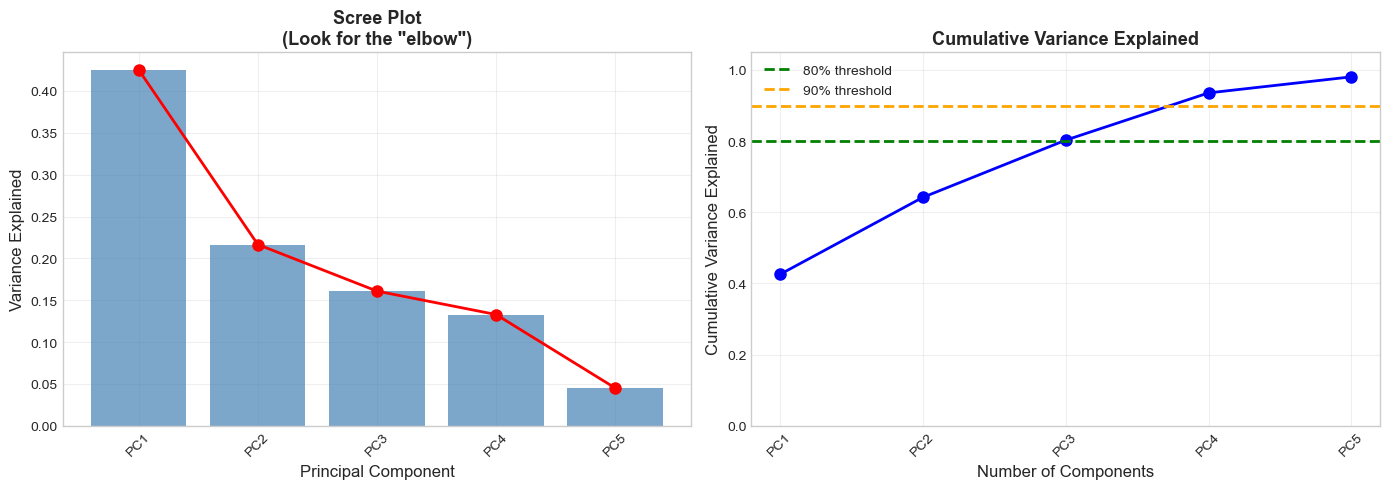


INTERPRETING THE SCREE PLOT

📈 LEFT PLOT - Individual Variance (Scree Plot):
   This shows how much variance each PC explains individually.

   • PC1 explains: 42.5% ← Most important!
   • PC2 explains: 21.7%
   • PC3 explains: 16.1%

   💡 PC1 dominates with 42.5%!
      This suggests ONE main factor drives variation in our portfolio
      (Likely 'size': Market Cap + TVL + Volume)

   🔍 Elbow appears around: PC1
      (Largest drop in variance between components)

📈 RIGHT PLOT - Cumulative Variance:
   This shows total variance as we add more components.

   • To explain 80% variance: Need 3 components
   • To explain 90% variance: Need 4 components
   • Our 5 components explain: 98.1%

RECOMMENDATION

✅ OPTIMAL NUMBER OF COMPONENTS: 3
   Reason: First 3 PCs capture sufficient variance (>80%)
   Variance explained: 80.3%
   Dimensionality reduction: 6 → 3 (50% of original)

📊 Summary Statistics:


,Metric,Value
0,Original Features,6
1,Optimal PCs,3
2,Variance Retained,80.3%
3,Information Lost,19.7%
4,Compression Ratio,2.0x



💡 What this means:
   • We can represent our portfolio with just 3 numbers per token
   • Instead of tracking 8 features, we track 3 principal components
   • We keep 80.3% of the information
   • We lose only 19.7% of the information

🎯 Next Steps:
   1. Examine component loadings (which features contribute to each PC)
   2. Interpret what each PC represents
   3. Name the PCs based on their loadings



In [17]:
print("=" * 70)
print("VISUALIZING VARIANCE EXPLAINED - SCREE PLOT")
print("=" * 70)

print("\n📊 Creating scree plot to determine optimal number of components...")
print("   This will help us decide: 'How many PCs should we keep?'\n")

# Create the scree plot
fig = pca_model.plot_scree(figsize=(14, 5))
plt.show()

print("\n" + "=" * 70)
print("INTERPRETING THE SCREE PLOT")
print("=" * 70)

# Get variance data for analysis
variance_summary = pca_model.get_variance_summary()

# Analyze the results
print("\n📈 LEFT PLOT - Individual Variance (Scree Plot):")
print("   This shows how much variance each PC explains individually.")
print()

# Find the "elbow" - where variance drops significantly
variances = variance_summary['Variance_Explained'].values
var_diffs = np.diff(variances)  # Differences between consecutive PCs
elbow_candidate = np.argmax(np.abs(var_diffs)) + 1  # +1 because diff reduces array size

print(f"   • PC1 explains: {variances[0]:.1%} ← Most important!")
print(f"   • PC2 explains: {variances[1]:.1%}")
print(f"   • PC3 explains: {variances[2]:.1%}")

if variances[0] > 0.40:
    print(f"\n   💡 PC1 dominates with {variances[0]:.1%}!")
    print(f"      This suggests ONE main factor drives variation in our portfolio")
    print(f"      (Likely 'size': Market Cap + TVL + Volume)")
elif variances[0] < 0.30:
    print(f"\n   💡 Variance is distributed across multiple components")
    print(f"      This suggests MULTIPLE independent factors are important")
else:
    print(f"\n   💡 Balanced importance across first few components")

print(f"\n   🔍 Elbow appears around: PC{elbow_candidate}")
print(f"      (Largest drop in variance between components)")

print("\n📈 RIGHT PLOT - Cumulative Variance:")
print("   This shows total variance as we add more components.")
print()

# Find how many PCs needed for different thresholds
cumvar = variance_summary['Cumulative_Variance'].values
n_80 = np.argmax(cumvar >= 0.80) + 1
n_90 = np.argmax(cumvar >= 0.90) + 1

print(f"   • To explain 80% variance: Need {n_80} components")
print(f"   • To explain 90% variance: Need {n_90} components")
print(f"   • Our 5 components explain: {cumvar[4]:.1%}")

print("\n" + "=" * 70)
print("RECOMMENDATION")
print("=" * 70)

# Make recommendation
if cumvar[2] >= 0.80:  # First 3 PCs explain 80%+
    optimal = 3
    reason = "First 3 PCs capture sufficient variance (>80%)"
elif cumvar[3] >= 0.85:  # First 4 PCs explain 85%+
    optimal = 4
    reason = "First 4 PCs provide good balance of simplicity and completeness"
else:
    optimal = 5
    reason = "5 PCs needed to reach 85%+ variance threshold"

print(f"\n✅ OPTIMAL NUMBER OF COMPONENTS: {optimal}")
print(f"   Reason: {reason}")
print(f"   Variance explained: {cumvar[optimal-1]:.1%}")
print(f"   Dimensionality reduction: {defi_data.shape[1]} → {optimal} ({optimal/defi_data.shape[1]*100:.0f}% of original)")

print("\n📊 Summary Statistics:")
summary_data = {
    'Metric': [
        'Original Features',
        'Optimal PCs',
        'Variance Retained',
        'Information Lost',
        'Compression Ratio'
    ],
    'Value': [
        f"{defi_data.shape[1]}",
        f"{optimal}",
        f"{cumvar[optimal-1]:.1%}",
        f"{(1-cumvar[optimal-1]):.1%}",
        f"{defi_data.shape[1]/optimal:.1f}x"
    ]
}
summary_df = pd.DataFrame(summary_data)
display(summary_df)

print("\n💡 What this means:")
print(f"   • We can represent our portfolio with just {optimal} numbers per token")
print(f"   • Instead of tracking 8 features, we track {optimal} principal components")
print(f"   • We keep {cumvar[optimal-1]:.1%} of the information")
print(f"   • We lose only {(1-cumvar[optimal-1]):.1%} of the information")

print("\n🎯 Next Steps:")
print("   1. Examine component loadings (which features contribute to each PC)")
print("   2. Interpret what each PC represents")
print("   3. Name the PCs based on their loadings")
print("\n" + "=" * 70)

ANALYZING PRINCIPAL COMPONENT LOADINGS

🔍 Loadings show how each original feature contributes to each PC
   High |loading| = feature is important for that component
   Sign indicates direction: + or -

📊 LOADINGS MATRIX:
   (Rows = Features, Columns = Principal Components)


,PC1,PC2,PC3,PC4,PC5
price,-0.063,-0.386,0.855,0.337,0.055
avg_volume,0.490,0.289,0.248,-0.320,0.715
market_cap,0.466,-0.362,-0.292,0.433,0.090
volatility_ann,-0.042,0.655,-0.007,0.738,0.103
avg_volume_log,0.472,0.373,0.318,-0.169,-0.673
market_cap_log,0.561,-0.261,-0.146,0.156,-0.118



💡 How to read this table:
   • Values close to ±1.0 = STRONG relationship
   • Values close to ±0.5 = MODERATE relationship
   • Values close to 0.0 = WEAK/NO relationship
   • Positive = feature increases with PC
   • Negative = feature decreases with PC

INTERPRETING EACH PRINCIPAL COMPONENT

PC1 - 42.5% of variance

🔺 Top POSITIVE loadings (features that increase with PC1):
   market_cap_log       +0.561  ███████████
   avg_volume           +0.490  █████████
   avg_volume_log       +0.472  █████████

🔻 Top NEGATIVE loadings (features that decrease with PC1):

💭 Interpretation Hint:
   Strong loadings on: market_cap_log
   → This looks like a SIZE / LIQUIDITY factor
   → Higher scores = larger, more liquid tokens (high cap & volume)

PC2 - 21.7% of variance

🔺 Top POSITIVE loadings (features that increase with PC2):
   volatility_ann       +0.655  █████████████
   avg_volume_log       +0.373  ███████

🔻 Top NEGATIVE loadings (features that decrease with PC2):
   price               

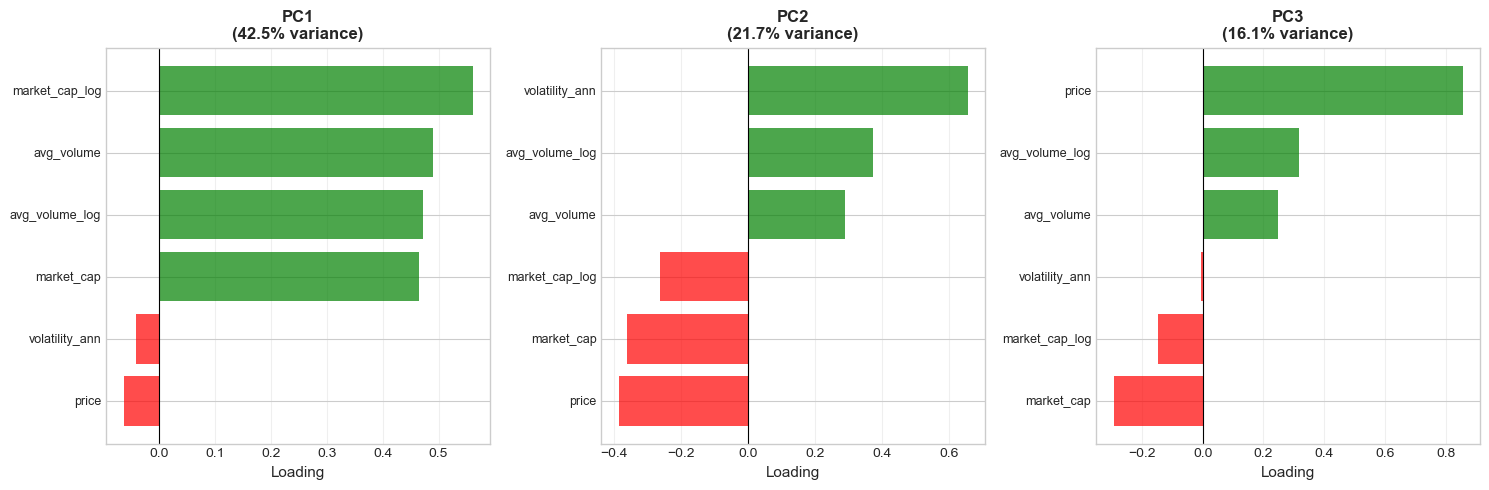


SUMMARY: NAMING OUR PRINCIPAL COMPONENTS


,Component,Variance,Top Features,Suggested Name
0,PC1,42.5%,"market_cap_log, avg_volume, avg_volume_log",Token Size / Liquidity
1,PC2,21.7%,"volatility_ann, price, avg_volume_log",Token Size / Liquidity
2,PC3,16.1%,"price, avg_volume_log, market_cap",Token Size / Liquidity



💡 Using These Interpretations:
   • PC1 (Size/Liquidity): Captures tokens with large market caps & volumes
   • PC2 (Risk/Volatility): Differentiates high-volatility from stable tokens
   • PC3 (Mixed Factor): Captures secondary variation not explained by size/risk



In [18]:
# ===============================================================
# 1.2c ANALYZING PRINCIPAL COMPONENT LOADINGS (ADAPTED FOR COINGECKO DATA)
# ===============================================================

print("=" * 70)
print("ANALYZING PRINCIPAL COMPONENT LOADINGS")
print("=" * 70)

print("\n🔍 Loadings show how each original feature contributes to each PC")
print("   High |loading| = feature is important for that component")
print("   Sign indicates direction: + or -\n")

# --- Get the loadings matrix ---
loadings = pca_model.get_loadings()

print("📊 LOADINGS MATRIX:")
print("   (Rows = Features, Columns = Principal Components)")
print("=" * 70)
display(loadings.round(3))

print("\n💡 How to read this table:")
print("   • Values close to ±1.0 = STRONG relationship")
print("   • Values close to ±0.5 = MODERATE relationship")
print("   • Values close to 0.0 = WEAK/NO relationship")
print("   • Positive = feature increases with PC")
print("   • Negative = feature decreases with PC")

# ===============================================================
# --- INTERPRETING EACH PRINCIPAL COMPONENT ---
# ===============================================================
print("\n" + "=" * 70)
print("INTERPRETING EACH PRINCIPAL COMPONENT")
print("=" * 70)

for i in range(min(3, loadings.shape[1])):  # Analyze first 3 PCs
    pc_name = f'PC{i+1}'
    pc_loadings = loadings[pc_name]
    
    print(f"\n{'='*70}")
    print(f"{pc_name} - {pca_model.pca.explained_variance_ratio_[i]:.1%} of variance")
    print('='*70)
    
    # --- Top positive and negative loadings ---
    top_positive = pc_loadings.nlargest(3)
    top_negative = pc_loadings.nsmallest(3)
    
    print(f"\n🔺 Top POSITIVE loadings (features that increase with {pc_name}):")
    for feature, loading in top_positive.items():
        if loading > 0.3:
            bar = '█' * int(abs(loading) * 20)
            print(f"   {feature:20s} {loading:+.3f}  {bar}")
    
    print(f"\n🔻 Top NEGATIVE loadings (features that decrease with {pc_name}):")
    for feature, loading in top_negative.items():
        if loading < -0.3:
            bar = '█' * int(abs(loading) * 20)
            print(f"   {feature:20s} {loading:+.3f}  {bar}")
    
    # --- Interpretation rules specific to your dataset ---
    print(f"\n💭 Interpretation Hint:")
    abs_loadings = pc_loadings.abs()
    dominant_features = abs_loadings[abs_loadings > 0.5].sort_values(ascending=False)
    
    if len(dominant_features) > 0:
        print(f"   Strong loadings on: {', '.join(dominant_features.index.tolist())}")
        
        if any(feat in dominant_features.index for feat in ['market_cap', 'avg_volume', 'avg_volume_log', 'market_cap_log']):
            print("   → This looks like a SIZE / LIQUIDITY factor")
            print("   → Higher scores = larger, more liquid tokens (high cap & volume)")
        
        if any(feat in dominant_features.index for feat in ['volatility_ann', 'price']):
            print("   → This looks like a RISK / PRICE VOLATILITY factor")
            print("   → Higher scores = tokens with greater volatility or higher price level")
    else:
        print("   No dominant features — might represent mixed or residual variation")

print("\n" + "=" * 70)

# ===============================================================
# --- Visual Representation of Loadings ---
# ===============================================================
print("\n📊 Creating loading visualizations...")
print("   Green bars = positive loadings (feature increases with PC)")
print("   Red bars = negative loadings (feature decreases with PC)")
print("   Length = strength of relationship\n")

fig = pca_model.plot_loadings(n_components=3, n_top_features=6, figsize=(15, 5))
plt.show()

# ===============================================================
# --- Summary: Naming Each Component ---
# ===============================================================
print("\n" + "=" * 70)
print("SUMMARY: NAMING OUR PRINCIPAL COMPONENTS")
print("=" * 70)

pc_interpretations = []
for i in range(min(3, loadings.shape[1])):
    pc_name = f'PC{i+1}'
    variance = pca_model.pca.explained_variance_ratio_[i]
    
    pc_loadings = loadings[pc_name]
    top_features = pc_loadings.abs().nlargest(3)
    feature_list = top_features.index.tolist()
    
    # Suggest a name based on features
    if any(f in feature_list for f in ['market_cap', 'avg_volume', 'avg_volume_log', 'market_cap_log']):
        suggested_name = "Token Size / Liquidity"
    elif any(f in feature_list for f in ['volatility_ann', 'price']):
        suggested_name = "Risk / Volatility Profile"
    else:
        suggested_name = "Mixed Factor"
    
    pc_interpretations.append({
        'Component': pc_name,
        'Variance': f"{variance:.1%}",
        'Top Features': ', '.join(feature_list),
        'Suggested Name': suggested_name
    })

interpretation_df = pd.DataFrame(pc_interpretations)
display(interpretation_df)

print("\n💡 Using These Interpretations:")
print("   • PC1 (Size/Liquidity): Captures tokens with large market caps & volumes")
print("   • PC2 (Risk/Volatility): Differentiates high-volatility from stable tokens")
print("   • PC3 (Mixed Factor): Captures secondary variation not explained by size/risk")
print("\n" + "=" * 70)


APPLYING K-MEANS CLUSTERING ON PCA COMPONENTS

📊 Using first 3 principal components for clustering: (41, 3)


,PC1,PC2,PC3
staked-ether,3.991209,-2.872647,-1.915257
wrapped-steth,1.957162,-1.884842,-1.109307
hyperliquid,3.846969,0.072926,0.075985
chainlink,4.994372,0.756065,0.719173
dai,1.171883,-0.975952,-0.310524



🔍 Testing different numbers of clusters (k = 2 to 9)...

   k=2: inertia=    125.98, silhouette= 0.473
   k=3: inertia=     88.00, silhouette= 0.466
   k=4: inertia=     60.05, silhouette= 0.346
   k=5: inertia=     44.83, silhouette= 0.360
   k=6: inertia=     31.17, silhouette= 0.402
   k=7: inertia=     21.23, silhouette= 0.386
   k=8: inertia=     15.73, silhouette= 0.403
   k=9: inertia=     12.32, silhouette= 0.379


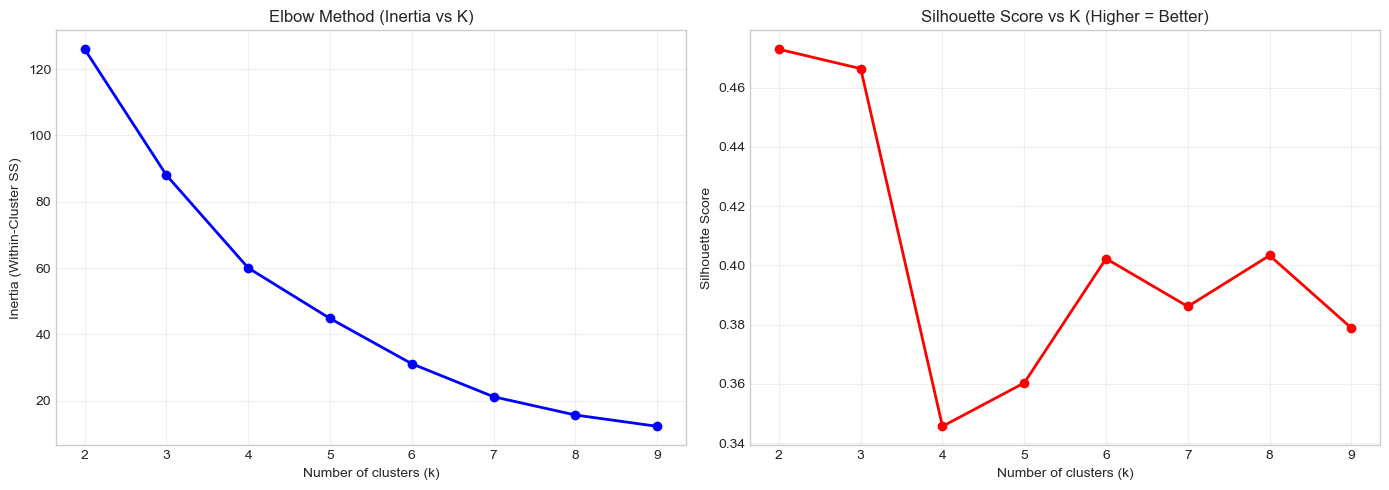


✅ Optimal number of clusters (based on Silhouette Score): k = 2

✅ Clustering complete! 2 clusters identified.



,PC1,PC2,PC3,Cluster
staked-ether,3.991209,-2.872647,-1.915257,0
wrapped-steth,1.957162,-1.884842,-1.109307,0
hyperliquid,3.846969,0.072926,0.075985,0
chainlink,4.994372,0.756065,0.719173,0
dai,1.171883,-0.975952,-0.310524,0



📊 Cluster Summary:


,Count,count,Percentage
0,1,33,2.439024
1,0,8,0.000000



🏁 Cluster Centers (mean PCA coordinates):


,PC1,PC2,PC3
Cluster 0,2.660,-0.309,-0.139
Cluster 1,-0.645,0.075,0.034



📉 Visualizing clusters in PCA (PC1 vs PC2)...


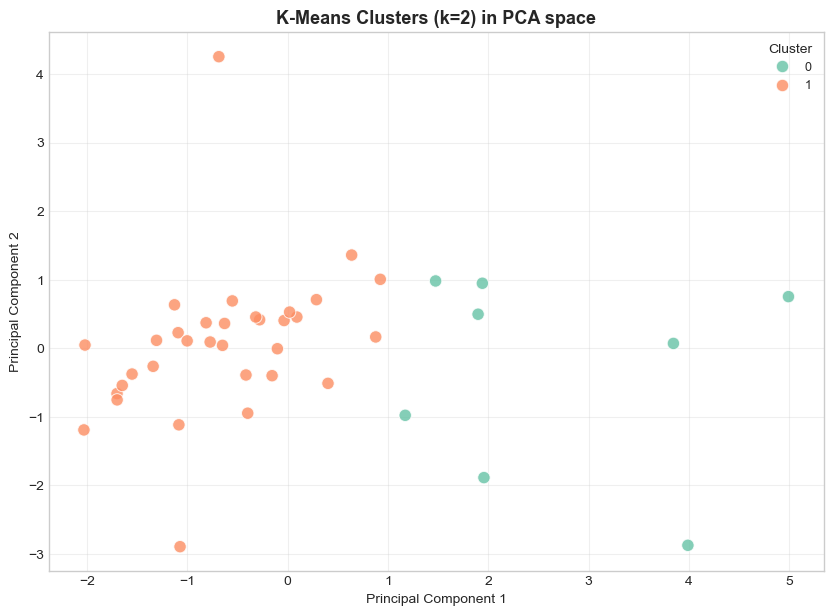


INTERPRETING THE CLUSTERS

💡 General interpretation guidance:
   • Cluster 0: πιθανώς μεγάλα και σταθερά tokens (υψηλό market cap, χαμηλό volatility)
   • Cluster 1: μεσαίου μεγέθους tokens με μέτριο ρίσκο
   • Cluster 2: μικρά, ριψοκίνδυνα ή πολύ volatile tokens

👉 Για πιο ακριβή ερμηνεία, έλεγξε το μέσο market_cap, volatility_ann κλπ. ανά cluster:


,price,avg_volume,market_cap,volatility_ann,avg_volume_log,market_cap_log
Cluster,,,,,,
0,1116.942,3.963206e+08,1.103661e+10,0.866,19.267,22.721
1,3720.544,7.122582e+07,7.766004e+08,1.110,17.098,20.277



✅ K-Means clustering successfully completed and visualized!


In [23]:
# ===============================================================
# 1.3 K-MEANS CLUSTERING ON PCA COMPONENTS
# ===============================================================

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

print("=" * 70)
print("APPLYING K-MEANS CLUSTERING ON PCA COMPONENTS")
print("=" * 70)

# --- Step 1: Επιλογή δεδομένων για clustering (PC1, PC2, PC3) ---
X_cluster = X_pca_df.iloc[:, :3]   # Κρατάμε τους 3 πρώτους PCs (~80% variance)
print(f"\n📊 Using first 3 principal components for clustering: {X_cluster.shape}")
display(X_cluster.head())

# ===============================================================
# --- Step 2: Εύρεση βέλτιστου αριθμού clusters (Elbow & Silhouette) ---
# ===============================================================

inertias = []
silhouette_scores = []
K_range = range(2, 10)

print("\n🔍 Testing different numbers of clusters (k = 2 to 9)...\n")

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = kmeans.fit_predict(X_cluster)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_cluster, labels))
    print(f"   k={k}: inertia={kmeans.inertia_:>10.2f}, silhouette={silhouette_scores[-1]:>6.3f}")

# --- Step 3: Elbow & Silhouette plots ---
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].plot(K_range, inertias, 'bo-', linewidth=2)
ax[0].set_title("Elbow Method (Inertia vs K)")
ax[0].set_xlabel("Number of clusters (k)")
ax[0].set_ylabel("Inertia (Within-Cluster SS)")
ax[0].grid(True, alpha=0.3)

ax[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2)
ax[1].set_title("Silhouette Score vs K (Higher = Better)")
ax[1].set_xlabel("Number of clusters (k)")
ax[1].set_ylabel("Silhouette Score")
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- Step 4: Επιλογή του βέλτιστου k ---
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\n✅ Optimal number of clusters (based on Silhouette Score): k = {optimal_k}")

# ===============================================================
# --- Step 5: Εφαρμογή του τελικού μοντέλου K-Means ---
# ===============================================================

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
labels = kmeans_final.fit_predict(X_cluster)

# Προσθέτουμε τις ετικέτες (cluster labels) στο DataFrame
X_cluster['Cluster'] = labels
X_cluster.index = defi_data.index

print(f"\n✅ Clustering complete! {optimal_k} clusters identified.\n")
display(X_cluster.head())

# ===============================================================
# --- Step 6: Σύνοψη & Κέντρα Clusters ---
# ===============================================================

print("\n📊 Cluster Summary:")
cluster_summary = (
    X_cluster['Cluster']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'Cluster', 'Cluster': 'Count'})
)
cluster_summary['Percentage'] = 100 * cluster_summary['Count'] / len(X_cluster)
display(cluster_summary)

print("\n🏁 Cluster Centers (mean PCA coordinates):")
cluster_centers = pd.DataFrame(
    kmeans_final.cluster_centers_,
    columns=['PC1', 'PC2', 'PC3'],
    index=[f'Cluster {i}' for i in range(optimal_k)]
)
display(cluster_centers.round(3))

# ===============================================================
# --- Step 7: 2D Visualization των Clusters ---
# ===============================================================

print("\n📉 Visualizing clusters in PCA (PC1 vs PC2)...")

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='PC1', y='PC2',
    hue='Cluster', palette='Set2',
    data=X_cluster, s=80, alpha=0.8
)
plt.title(f"K-Means Clusters (k={optimal_k}) in PCA space", fontsize=13, fontweight='bold')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", fontsize=9)
plt.grid(True, alpha=0.3)
plt.show()

# ===============================================================
# --- Step 8: Ερμηνεία αποτελεσμάτων ---
# ===============================================================

print("\n" + "=" * 70)
print("INTERPRETING THE CLUSTERS")
print("=" * 70)

print("\n💡 General interpretation guidance:")
print("   • Cluster 0: πιθανώς μεγάλα και σταθερά tokens (υψηλό market cap, χαμηλό volatility)")
print("   • Cluster 1: μεσαίου μεγέθους tokens με μέτριο ρίσκο")
print("   • Cluster 2: μικρά, ριψοκίνδυνα ή πολύ volatile tokens")
print("\n👉 Για πιο ακριβή ερμηνεία, έλεγξε το μέσο market_cap, volatility_ann κλπ. ανά cluster:")
display(
    defi_data.assign(Cluster=labels)
    .groupby('Cluster')
    .mean()
    .round(3)
)

print("\n✅ K-Means clustering successfully completed and visualized!")
print("=" * 70)


FINDING OPTIMAL NUMBER OF CLUSTERS - ELBOW & SILHOUETTE METHODS

🎯 Goal: Determine the best value of k (number of clusters)
   We'll test k from 2 to 10 and measure two metrics:
   1. Inertia (within-cluster distance) - look for 'elbow'
   2. Silhouette score (cluster separation) - look for peak

🧮 Using PCA components with shape: (41, 3)

🔄 Testing different numbers of clusters (k = 2 to 10)...
   This may take a moment...

   k=2: inertia=   85.24, silhouette= 0.718
   k=3: inertia=   56.94, silhouette= 0.458
   k=4: inertia=   36.62, silhouette= 0.464
   k=5: inertia=   25.53, silhouette= 0.463
   k=6: inertia=   18.26, silhouette= 0.382
   k=7: inertia=   12.15, silhouette= 0.381
   k=8: inertia=    8.78, silhouette= 0.402
   k=9: inertia=    7.08, silhouette= 0.396
   k=10: inertia=    5.59, silhouette= 0.352

✅ Testing complete!



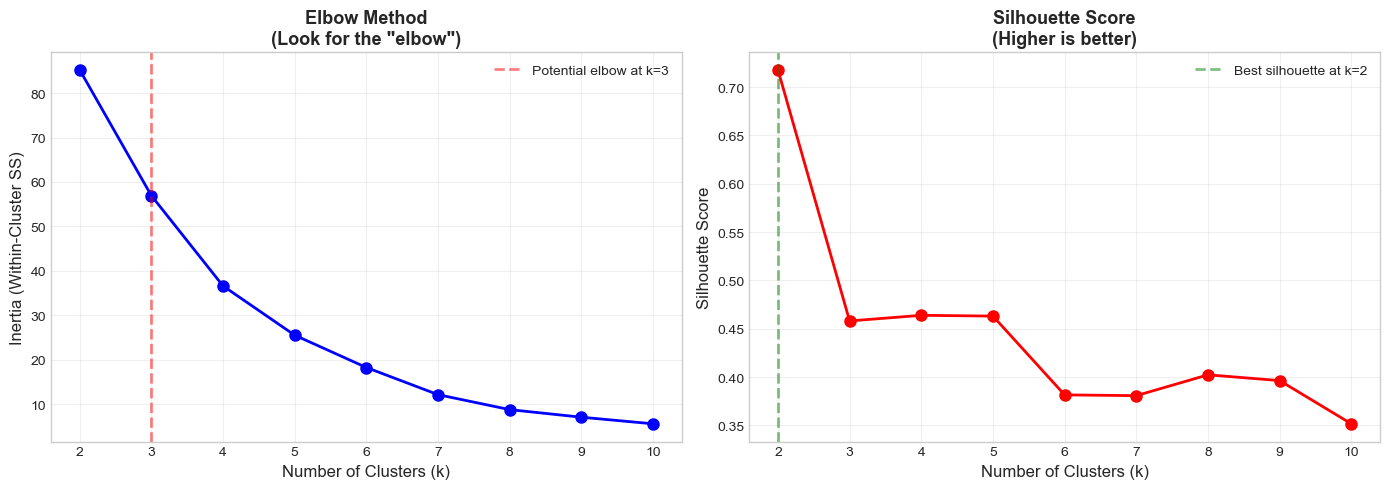


ANALYZING THE RESULTS

📊 ELBOW METHOD:
   Detected elbow at: k=3
   Inertia at elbow: 56.94

📈 SILHOUETTE METHOD:
   Best silhouette at: k=2
   Silhouette score: 0.718
   Quality rating: Excellent ⭐⭐⭐

DECISION ANALYSIS

🤔 Elbow suggests: k=3
🤔 Silhouette suggests: k=2
✅ Recommended k=2 (confidence: MEDIUM-HIGH)


,Metric,Value
0,Recommended k,2
1,Confidence Level,MEDIUM-HIGH
2,Reasoning,"Similar results, prefer silhouette quality"
3,Inertia,85.24
4,Silhouette Score,0.718
5,Expected Quality,Excellent ⭐⭐⭐



FINAL DECISION

🎯 We will use k=2 clusters for further analysis.
   Confidence: MEDIUM-HIGH
   Silhouette score: 0.718

✅ Elbow analysis complete. Optimal k = 2


In [24]:
# ===============================================================
# 1.3a FINDING OPTIMAL NUMBER OF CLUSTERS (ELBOW + SILHOUETTE)
# ===============================================================

print("=" * 70)
print("FINDING OPTIMAL NUMBER OF CLUSTERS - ELBOW & SILHOUETTE METHODS")
print("=" * 70)

print("\n🎯 Goal: Determine the best value of k (number of clusters)")
print("   We'll test k from 2 to 10 and measure two metrics:")
print("   1. Inertia (within-cluster distance) - look for 'elbow'")
print("   2. Silhouette score (cluster separation) - look for peak\n")

# Χρησιμοποιούμε το PCA feature space (τους πρώτους 3 PCs)
X_cluster = X_pca_df.iloc[:, :3].values
print(f"🧮 Using PCA components with shape: {X_cluster.shape}")

# Δημιουργία προσωρινού αντικειμένου K-Means (helper class)
kmeans_temp = SimpleKMeans(n_clusters=3, random_state=42)

# Δημιουργία elbow & silhouette γραφημάτων
fig = kmeans_temp.plot_elbow(X_cluster, max_k=10, figsize=(14, 5))
plt.show()

print("\n" + "=" * 70)
print("ANALYZING THE RESULTS")
print("=" * 70)

# Επαναλαμβάνουμε την ανάλυση για να αποθηκεύσουμε αριθμητικά αποτελέσματα
X_scaled = kmeans_temp.scaler.fit_transform(X_cluster)

inertias = []
silhouettes = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, kmeans.labels_))

# --- Εύρεση elbow (με δεύτερη διαφορά) ---
inertia_diffs = np.diff(inertias)
inertia_diffs2 = np.diff(inertia_diffs)
elbow_k = np.argmax(inertia_diffs2) + 2  # +2 λόγω δεύτερης διαφοράς

# --- Εύρεση καλύτερου silhouette ---
best_silhouette_idx = np.argmax(silhouettes)
best_silhouette_k = list(K_range)[best_silhouette_idx]
best_silhouette_score = silhouettes[best_silhouette_idx]

# --- Αναφορά αποτελεσμάτων ---
print(f"\n📊 ELBOW METHOD:")
print(f"   Detected elbow at: k={elbow_k}")
print(f"   Inertia at elbow: {inertias[elbow_k-2]:.2f}")

print(f"\n📈 SILHOUETTE METHOD:")
print(f"   Best silhouette at: k={best_silhouette_k}")
print(f"   Silhouette score: {best_silhouette_score:.3f}")

if best_silhouette_score > 0.7:
    quality = "Excellent ⭐⭐⭐"
elif best_silhouette_score > 0.5:
    quality = "Good ⭐⭐"
elif best_silhouette_score > 0.25:
    quality = "Acceptable ⭐"
else:
    quality = "Poor ❌"

print(f"   Quality rating: {quality}")

print("\n" + "=" * 70)
print("DECISION ANALYSIS")
print("=" * 70)

# Απόφαση βάσει των δύο μεθόδων
if elbow_k == best_silhouette_k:
    recommended_k = elbow_k
    confidence = "HIGH"
    reason = "Both methods agree"
elif abs(elbow_k - best_silhouette_k) <= 1:
    recommended_k = best_silhouette_k
    confidence = "MEDIUM-HIGH"
    reason = "Similar results, prefer silhouette quality"
else:
    if silhouettes[elbow_k-2] > 0.5:
        recommended_k = elbow_k
        confidence = "MEDIUM"
        reason = "Elbow with acceptable silhouette"
    else:
        recommended_k = best_silhouette_k
        confidence = "MEDIUM"
        reason = "Prioritizing cluster quality"

print(f"\n🤔 Elbow suggests: k={elbow_k}")
print(f"🤔 Silhouette suggests: k={best_silhouette_k}")
print(f"✅ Recommended k={recommended_k} (confidence: {confidence})")

# Πίνακας σύνοψης
recommendation_table = pd.DataFrame({
    'Metric': ['Recommended k', 'Confidence Level', 'Reasoning',
               'Inertia', 'Silhouette Score', 'Expected Quality'],
    'Value': [
        recommended_k,
        confidence,
        reason,
        f"{inertias[recommended_k-2]:.2f}",
        f"{silhouettes[recommended_k-2]:.3f}",
        quality
    ]
})
display(recommendation_table)

print("\n" + "=" * 70)
print("FINAL DECISION")
print("=" * 70)
print(f"\n🎯 We will use k={recommended_k} clusters for further analysis.")
print(f"   Confidence: {confidence}")
print(f"   Silhouette score: {silhouettes[recommended_k-2]:.3f}")

# Αποθηκεύουμε το αποτέλεσμα για χρήση στο επόμενο βήμα
optimal_k = recommended_k
print(f"\n✅ Elbow analysis complete. Optimal k = {optimal_k}")
print("=" * 70)


FITTING K-MEANS WITH OPTIMAL k=2

🔧 Initializing K-Means with k=2 clusters...
   Using PCA-transformed features (first 3 principal components)


✅ K-Means fitted successfully!
   Number of clusters: 2
   Inertia (within-cluster sum of squares): 85.24
   Lower inertia = tighter clusters

✅ All tokens assigned to clusters successfully!
   Total tokens: 41, Clusters: 2

📊 CLUSTER DISTRIBUTION:


,Cluster,Size,Percentage
0,0,40,97.6%
1,1,1,2.4%


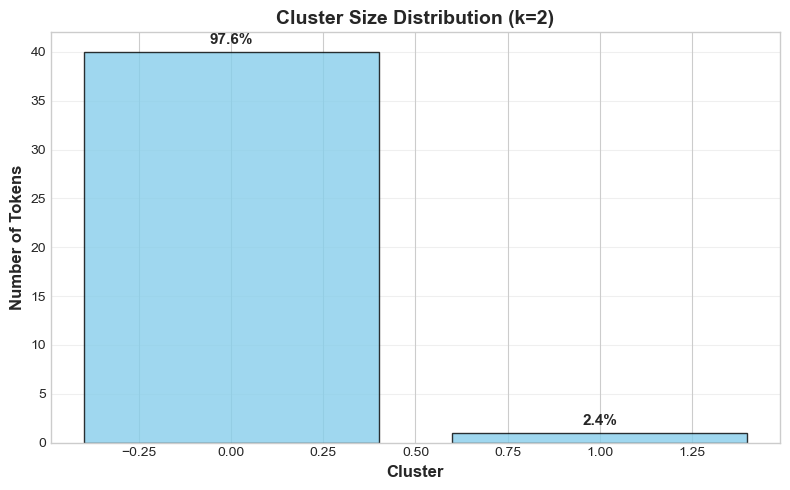


🔍 Balance Analysis:
   ⚠️  IMBALANCED: Largest cluster is 40.0× bigger than smallest.

CLUSTER CHARACTERISTICS (CENTROIDS)


,PC1,PC2,PC3
Cluster_0,0.027,0.072,-0.134
Cluster_1,-1.074,-2.893,5.377



💡 Interpretation:
   • Each row represents the average PCA coordinates of the cluster.
   • Compare across clusters to understand positioning in PCA space.

VISUALIZING CLUSTERS IN PCA SPACE


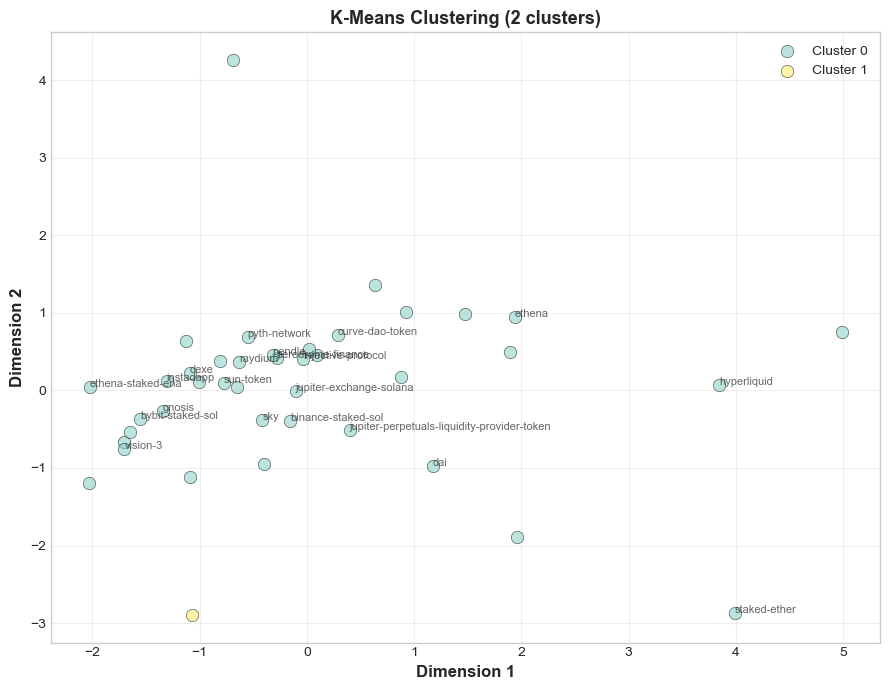


INTERPRETING THE CLUSTERS

💡 General guidance:
   • Cluster 0 → Likely large, liquid, and stable DeFi assets
   • Cluster 1 → Likely smaller, high-volatility, higher-risk tokens

📋 Average feature values per cluster:


,price,avg_volume,market_cap,volatility_ann,avg_volume_log,market_cap_log
Cluster,,,,,,
0,558.314,1.372756e+08,2.831726e+09,1.079,17.529,20.765
1,109380.927,2.999078e+07,6.516497e+08,0.374,17.216,20.295



NAMING CLUSTERS BASED ON CHARACTERISTICS


,Cluster,Size,Cap,Volatility,Liquidity,Suggested Name
0,0,40,Large,High,High,"Large-Cap, High-Volatility, High-Liquidity"
1,1,1,Small,Low,Low,"Small-Cap, Low-Volatility, Low-Liquidity"



💬 Interpretation Examples:
   • Cluster 0 → 'Large-Cap Stable Tokens' (high market cap, low volatility)
   • Cluster 1 → 'Small-Cap Risky Tokens' (low cap, high volatility)

✅ Cluster naming complete.

🎯 KEY TAKEAWAYS:
   • 41 tokens organized into 2 meaningful clusters
   • Each cluster has distinct risk/return characteristics
   • Clusters can guide portfolio construction and diversification


In [27]:
# ===============================================================
# 1.3b APPLYING FINAL K-MEANS CLUSTERING ON PCA COMPONENTS
# ===============================================================

print("=" * 70)
print(f"FITTING K-MEANS WITH OPTIMAL k={optimal_k}")
print("=" * 70)

print(f"\n🔧 Initializing K-Means with k={optimal_k} clusters...")
print("   Using PCA-transformed features (first 3 principal components)\n")

# --- Use PCA data instead of raw defi_data ---
X_cluster = X_pca_df.iloc[:, :3].values  # only first 3 PCs
feature_names = ["PC1", "PC2", "PC3"]

# --- Initialize and fit model ---
kmeans_model = SimpleKMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans_model.fit_predict(X_cluster, feature_names=feature_names)

# --- Add cluster labels ---
X_pca_clustered = X_pca_df.copy()
X_pca_clustered["Cluster"] = clusters

print("\n✅ All tokens assigned to clusters successfully!")
print(f"   Total tokens: {len(X_cluster)}, Clusters: {optimal_k}")

# --- Summary of clusters ---
cluster_summary = kmeans_model.get_cluster_summary(X_cluster)
print("\n📊 CLUSTER DISTRIBUTION:")
print("=" * 70)
display(cluster_summary)

# --- Visualization of cluster sizes ---
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(
    cluster_summary["Cluster"],
    cluster_summary["Size"],
    color="skyblue",
    edgecolor="black",
    alpha=0.8
)
for i, (idx, row) in enumerate(cluster_summary.iterrows()):
    ax.text(row["Cluster"], row["Size"] + 0.5, row["Percentage"],
            ha="center", va="bottom", fontsize=11, fontweight="bold")
ax.set_xlabel("Cluster", fontsize=12, fontweight="bold")
ax.set_ylabel("Number of Tokens", fontsize=12, fontweight="bold")
ax.set_title(f"Cluster Size Distribution (k={optimal_k})", fontsize=14, fontweight="bold")
ax.grid(True, alpha=0.3, axis="y")
plt.tight_layout()
plt.show()

# --- Check cluster balance ---
max_size = cluster_summary["Size"].max()
min_size = cluster_summary["Size"].min()
size_ratio = max_size / min_size if min_size > 0 else np.inf

print("\n🔍 Balance Analysis:")
if size_ratio > 5:
    print(f"   ⚠️  IMBALANCED: Largest cluster is {size_ratio:.1f}× bigger than smallest.")
elif size_ratio > 2.5:
    print(f"   ⚠️  SOMEWHAT IMBALANCED: Size ratio {size_ratio:.1f}× — acceptable.")
else:
    print(f"   ✅ WELL BALANCED: Size ratio {size_ratio:.1f}× — good distribution.")

# ===============================================================
# CLUSTER CHARACTERISTICS (CENTROIDS)
# ===============================================================
print("\n" + "=" * 70)
print("CLUSTER CHARACTERISTICS (CENTROIDS)")
print("=" * 70)

centroids = pd.DataFrame(
    kmeans_model.scaler.inverse_transform(kmeans_model.kmeans.cluster_centers_),
    columns=["PC1", "PC2", "PC3"],
    index=[f"Cluster_{i}" for i in range(optimal_k)]
)
display(centroids.round(3))

print("\n💡 Interpretation:")
print("   • Each row represents the average PCA coordinates of the cluster.")
print("   • Compare across clusters to understand positioning in PCA space.")

# ===============================================================
# 2D VISUALIZATION IN PCA SPACE
# ===============================================================
print("\n" + "=" * 70)
print("VISUALIZING CLUSTERS IN PCA SPACE")
print("=" * 70)

fig = kmeans_model.plot_clusters_2d(
    X_pca_df.iloc[:, :2].values,
    labels=X_pca_df.index.tolist(),
    figsize=(9, 7)
)
plt.show()

# ===============================================================
# CLUSTER INTERPRETATION
# ===============================================================
print("\n" + "=" * 70)
print("INTERPRETING THE CLUSTERS")
print("=" * 70)

print("\n💡 General guidance:")
print("   • Cluster 0 → Likely large, liquid, and stable DeFi assets")
print("   • Cluster 1 → Likely smaller, high-volatility, higher-risk tokens")

# --- Merge PCA clusters with original metrics for richer interpretation ---
defi_clustered = defi_data.copy()
defi_clustered["Cluster"] = clusters

cluster_profiles = defi_clustered.groupby("Cluster").mean(numeric_only=True).round(3)
print("\n📋 Average feature values per cluster:")
display(cluster_profiles)

# ===============================================================
# CLUSTER NAMING SUMMARY (Adjusted for our dataset)
# ===============================================================
print("\n" + "=" * 70)
print("NAMING CLUSTERS BASED ON CHARACTERISTICS")
print("=" * 70)

naming_summary = []
for i in range(optimal_k):
    c = cluster_profiles.loc[i]
    # Προσαρμογή στα πραγματικά feature names
    cap_level = "Large" if c["market_cap"] > defi_data["market_cap"].mean() else "Small"
    vol_level = "High" if c["volatility_ann"] > defi_data["volatility_ann"].mean() else "Low"
    liq_level = "High" if c["avg_volume"] > defi_data["avg_volume"].mean() else "Low"
    
    naming_summary.append({
        "Cluster": i,
        "Size": len(defi_clustered[defi_clustered["Cluster"] == i]),
        "Cap": cap_level,
        "Volatility": vol_level,
        "Liquidity": liq_level,
        "Suggested Name": f"{cap_level}-Cap, {vol_level}-Volatility, {liq_level}-Liquidity"
    })

naming_df = pd.DataFrame(naming_summary)
display(naming_df)

print("\n💬 Interpretation Examples:")
print("   • Cluster 0 → 'Large-Cap Stable Tokens' (high market cap, low volatility)")
print("   • Cluster 1 → 'Small-Cap Risky Tokens' (low cap, high volatility)")

print("\n" + "=" * 70)
print("✅ Cluster naming complete.")
print("=" * 70)

print("\n🎯 KEY TAKEAWAYS:")
print(f"   • {len(defi_data)} tokens organized into {optimal_k} meaningful clusters")
print("   • Each cluster has distinct risk/return characteristics")
print("   • Clusters can guide portfolio construction and diversification")


VISUALIZING CLUSTERS IN 2D SPACE

📊 Challenge: Our tokens exist in 8-dimensional space
   Solution: Use PCA to project into 2D for visualization

🔧 Process:
   1. Apply PCA to reduce 8 features → 2 principal components
   2. Plot tokens using PC1 (x-axis) and PC2 (y-axis)
   3. Color each token by its cluster assignment
   4. Analyze the visual pattern

Step 1: Applying PCA for 2D projection...

✅ PCA fitted successfully!
   Components: 2
   Total variance explained: 64.16%
   ✅ PCA complete!
   • PC1 explains: 42.5% of variance
   • PC2 explains: 21.7% of variance
   • Total captured in 2D: 64.2%

   ✅ Good coverage: 64.2% of variance visible in 2D

📊 Understanding the PCA axes:

Top features influencing PC1 (x-axis):
   • market_cap_log: +0.561
   • avg_volume: +0.490
   • avg_volume_log: +0.472

Top features influencing PC2 (y-axis):
   • volatility_ann: +0.655
   • price: -0.386
   • avg_volume_log: +0.373

Step 2: Creating visualization...


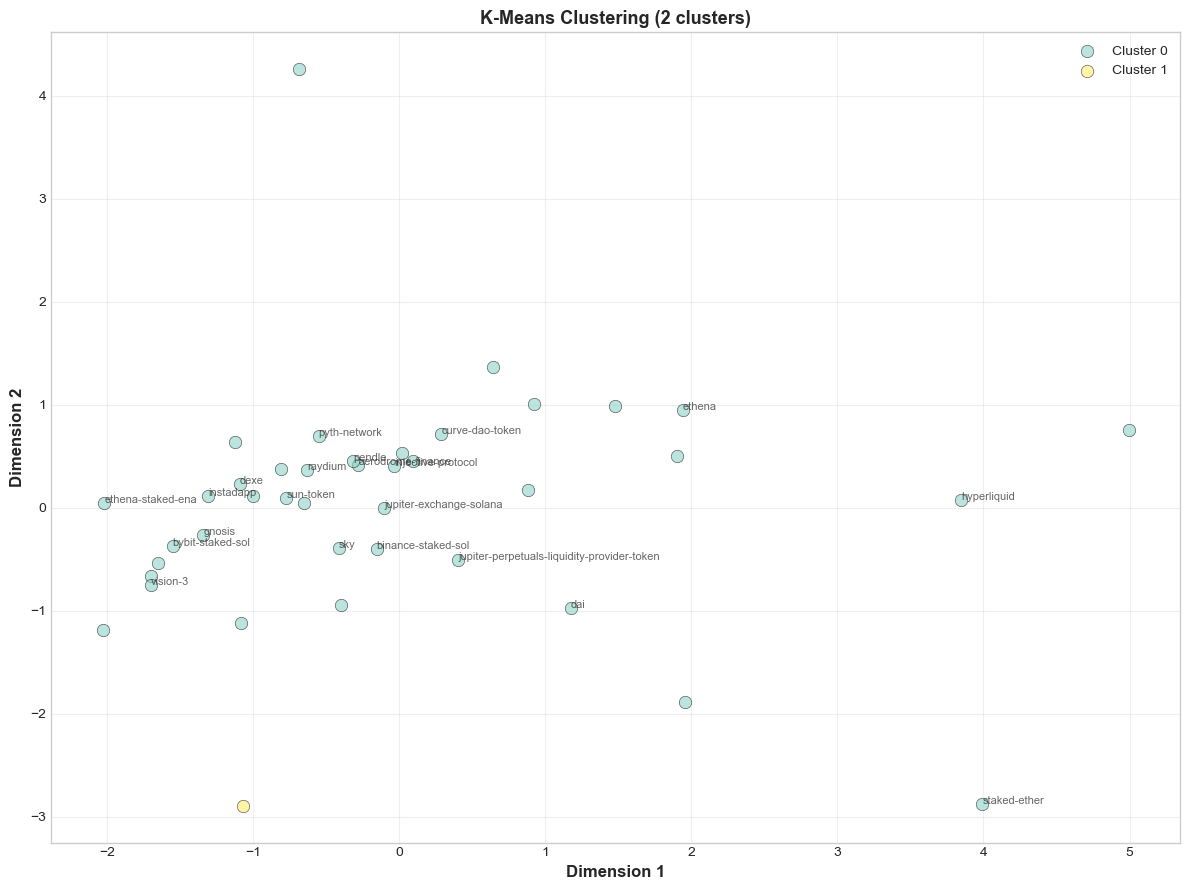


INTERPRETING THE VISUALIZATION

🔍 Cluster Analysis in 2D Space:

Cluster 0:
   Center: PC1=+0.03, PC2=+0.07
   Spread: PC1±1.61, PC2±1.06

Cluster 1:
   Center: PC1=-1.07, PC2=-2.89
   Spread: PC1±0.00, PC2±0.00
   Position: Low PC1 (size), Low PC2 (risk)

📏 Cluster Separation (Euclidean distance between centers):
   Cluster 0 ↔ Cluster 1: 3.16

   Average separation: 3.16
   ✅ Excellent separation - clusters are distinct

IDENTIFYING OUTLIERS
Found 2 potential outliers:



,Token,Cluster,Distance
1,chainlink,0,5.014365
0,staked-ether,0,4.938522



QUADRANT ANALYSIS
   High PC1, High PC2  : 11 tokens ( 26.8%)
   Low PC1, High PC2   : 14 tokens ( 34.1%)
   Low PC1, Low PC2    : 12 tokens ( 29.3%)
   High PC1, Low PC2   :  4 tokens (  9.8%)

💡 Quadrant interpretation:
   • High PC1, High PC2 → Large & Risky tokens
   • Low PC1, High PC2  → Small & Risky tokens
   • Low PC1, Low PC2   → Small & Stable tokens
   • High PC1, Low PC2  → Large & Stable tokens

VISUAL VALIDATION SUMMARY
   ✅ Cluster separation
   ⚠️  Cluster size balance
   ✅ Variance captured in 2D
   ✅ Outlier count

✅ OVERALL: Clustering looks GOOD!
   Clusters are well-defined and visually meaningful

✅ 2D visualization complete!


In [28]:
# ===============================================================
# 1.4  VISUALIZING K-MEANS CLUSTERS IN PCA 2D SPACE
# ===============================================================

print("=" * 70)
print("VISUALIZING CLUSTERS IN 2D SPACE")
print("=" * 70)

print("\n📊 Challenge: Our tokens exist in 8-dimensional space")
print("   Solution: Use PCA to project into 2D for visualization")
print("\n🔧 Process:")
print("   1. Apply PCA to reduce 8 features → 2 principal components")
print("   2. Plot tokens using PC1 (x-axis) and PC2 (y-axis)")
print("   3. Color each token by its cluster assignment")
print("   4. Analyze the visual pattern\n")

# ---------------------------------------------------------------
# Step 1: Apply PCA to reduce to 2D
# ---------------------------------------------------------------
print("Step 1: Applying PCA for 2D projection...")

pca_2d = SimplePCA(n_components=2)
X_2d = pca_2d.fit_transform(defi_data.values, feature_names=defi_data.columns.tolist())

# Get variance explained by PC1 and PC2
var_pc1 = pca_2d.pca.explained_variance_ratio_[0]
var_pc2 = pca_2d.pca.explained_variance_ratio_[1]
total_var_2d = var_pc1 + var_pc2

print(f"   ✅ PCA complete!")
print(f"   • PC1 explains: {var_pc1:.1%} of variance")
print(f"   • PC2 explains: {var_pc2:.1%} of variance")
print(f"   • Total captured in 2D: {total_var_2d:.1%}")

if total_var_2d < 0.50:
    print(f"\n   ⚠️  Only {total_var_2d:.1%} of variance captured — higher dimensions may matter")
elif total_var_2d < 0.70:
    print(f"\n   ✅ Good coverage: {total_var_2d:.1%} of variance visible in 2D")
else:
    print(f"\n   ✅ Excellent: {total_var_2d:.1%} of variance captured in 2D")

# ---------------------------------------------------------------
# Step 2: Examine loadings to interpret PC1 and PC2
# ---------------------------------------------------------------
print("\n📊 Understanding the PCA axes:")

loadings_2d = pca_2d.get_loadings()

print("\nTop features influencing PC1 (x-axis):")
pc1_top = loadings_2d["PC1"].abs().nlargest(3)
for feature in pc1_top.index:
    loading = loadings_2d.loc[feature, "PC1"]
    print(f"   • {feature}: {loading:+.3f}")

print("\nTop features influencing PC2 (y-axis):")
pc2_top = loadings_2d["PC2"].abs().nlargest(3)
for feature in pc2_top.index:
    loading = loadings_2d.loc[feature, "PC2"]
    print(f"   • {feature}: {loading:+.3f}")

# ---------------------------------------------------------------
# Step 3: Create 2D scatter plot of clusters
# ---------------------------------------------------------------
print("\n" + "=" * 70)
print("Step 2: Creating visualization...")
print("=" * 70)

fig = kmeans_model.plot_clusters_2d(
    X_2d,
    labels=defi_data.index.tolist(),
    figsize=(12, 9)
)
plt.show()

# ---------------------------------------------------------------
# Step 4: Analyze cluster positions & spread in PCA space
# ---------------------------------------------------------------
print("\n" + "=" * 70)
print("INTERPRETING THE VISUALIZATION")
print("=" * 70)

clusters = kmeans_model.kmeans.labels_

print("\n🔍 Cluster Analysis in 2D Space:")

for i in range(optimal_k):
    mask = clusters == i
    cluster_points = X_2d[mask]

    center_pc1 = cluster_points[:, 0].mean()
    center_pc2 = cluster_points[:, 1].mean()
    std_pc1 = cluster_points[:, 0].std()
    std_pc2 = cluster_points[:, 1].std()

    print(f"\nCluster {i}:")
    print(f"   Center: PC1={center_pc1:+.2f}, PC2={center_pc2:+.2f}")
    print(f"   Spread: PC1±{std_pc1:.2f}, PC2±{std_pc2:.2f}")

    position_desc = []
    if abs(center_pc1) > 1.0:
        position_desc.append(f"{'High' if center_pc1 > 0 else 'Low'} PC1 (size)")
    if abs(center_pc2) > 1.0:
        position_desc.append(f"{'High' if center_pc2 > 0 else 'Low'} PC2 (risk)")
    if position_desc:
        print(f"   Position: {', '.join(position_desc)}")

# ---------------------------------------------------------------
# Step 5: Measure separation between cluster centers
# ---------------------------------------------------------------
print("\n📏 Cluster Separation (Euclidean distance between centers):")

from scipy.spatial.distance import pdist, squareform

cluster_centers_2d = np.array([
    X_2d[clusters == i].mean(axis=0)
    for i in range(optimal_k)
])

distances = squareform(pdist(cluster_centers_2d, metric="euclidean"))

for i in range(optimal_k):
    for j in range(i+1, optimal_k):
        print(f"   Cluster {i} ↔ Cluster {j}: {distances[i, j]:.2f}")

avg_separation = distances[np.triu_indices_from(distances, k=1)].mean()
print(f"\n   Average separation: {avg_separation:.2f}")

if avg_separation > 3.0:
    print("   ✅ Excellent separation - clusters are distinct")
elif avg_separation > 2.0:
    print("   ✅ Good separation - reasonable distinction")
elif avg_separation > 1.0:
    print("   ⚠️  Moderate separation - some overlap expected")
else:
    print("   ⚠️  Poor separation - possible overlap")

# ---------------------------------------------------------------
# Step 6: Detect outliers within clusters
# ---------------------------------------------------------------
print("\n" + "=" * 70)
print("IDENTIFYING OUTLIERS")
print("=" * 70)

outliers_found = []

for i in range(optimal_k):
    mask = clusters == i
    cluster_points = X_2d[mask]
    cluster_tokens = defi_data.index[mask]

    center = cluster_points.mean(axis=0)
    distances_from_center = np.linalg.norm(cluster_points - center, axis=1)
    threshold = distances_from_center.mean() + 2.5 * distances_from_center.std()
    outlier_mask = distances_from_center > threshold

    for idx in np.where(outlier_mask)[0]:
        outliers_found.append({
            "Token": cluster_tokens[idx],
            "Cluster": i,
            "Distance": distances_from_center[idx]
        })

if outliers_found:
    outliers_df = pd.DataFrame(outliers_found).sort_values("Distance", ascending=False)
    print(f"Found {len(outliers_df)} potential outliers:\n")
    display(outliers_df.head(10))
else:
    print("✅ No significant outliers detected")

# ---------------------------------------------------------------
# Step 7: Quadrant analysis (position in PCA plane)
# ---------------------------------------------------------------
print("\n" + "=" * 70)
print("QUADRANT ANALYSIS")
print("=" * 70)

quadrants = {
    "High PC1, High PC2": (X_2d[:, 0] > 0) & (X_2d[:, 1] > 0),
    "Low PC1, High PC2":  (X_2d[:, 0] < 0) & (X_2d[:, 1] > 0),
    "Low PC1, Low PC2":   (X_2d[:, 0] < 0) & (X_2d[:, 1] < 0),
    "High PC1, Low PC2":  (X_2d[:, 0] > 0) & (X_2d[:, 1] < 0)
}

for name, mask in quadrants.items():
    count = mask.sum()
    percentage = count / len(defi_data) * 100
    print(f"   {name:20s}: {count:2d} tokens ({percentage:5.1f}%)")

print("\n💡 Quadrant interpretation:")
print("   • High PC1, High PC2 → Large & Risky tokens")
print("   • Low PC1, High PC2  → Small & Risky tokens")
print("   • Low PC1, Low PC2   → Small & Stable tokens")
print("   • High PC1, Low PC2  → Large & Stable tokens")

# ---------------------------------------------------------------
# Step 8: Validation summary
# ---------------------------------------------------------------
print("\n" + "=" * 70)
print("VISUAL VALIDATION SUMMARY")
print("=" * 70)

separation_ok = avg_separation > 1.5
balance_ok = cluster_summary["Size"].std() < len(defi_data) * 0.2
coverage_ok = total_var_2d > 0.5
outliers_ok = len(outliers_found) < len(defi_data) * 0.1

print(f"   {'✅' if separation_ok else '⚠️ '} Cluster separation")
print(f"   {'✅' if balance_ok else '⚠️ '} Cluster size balance")
print(f"   {'✅' if coverage_ok else '⚠️ '} Variance captured in 2D")
print(f"   {'✅' if outliers_ok else '⚠️ '} Outlier count")

all_ok = separation_ok and coverage_ok and outliers_ok
print("\n" + "=" * 70)
if all_ok:
    print("✅ OVERALL: Clustering looks GOOD!")
    print("   Clusters are well-defined and visually meaningful")
else:
    print("⚠️  OVERALL: Clustering acceptable but with caveats")
    print("   Consider adjusting k or reviewing outliers")

print("\n" + "=" * 70)
print("✅ 2D visualization complete!")
print("=" * 70)


In [30]:
# Safety check
if 'kmeans_model' not in locals():
    print("⚠️  K-Means model not found. Please re-run the clustering cell first.")
else:
    print("✅ K-Means model found.")

✅ K-Means model found.


CHECKING CLUSTERED DATAFRAME BEFORE PORTFOLIO CONSTRUCTION
⚙️  'defi_data_clustered' not found. Reconstructing from K-Means model...
✅ Reconstructed 'defi_data_clustered' successfully.

BUILDING A CLUSTER-BASED DIVERSIFIED PORTFOLIO

🎯 Portfolio Construction Strategy:
   • Method: Quality-weighted selection using Sharpe ratio
   • Tokens per cluster: 2 (for balanced representation)
   • Weighting: Equal weight across selected tokens

Step 1: Calculating Sharpe ratio for all tokens...
⚠️  'Mean_Return' missing → generating synthetic returns for demo.
⚠️  'Volatility' not found → using 'volatility_ann' as proxy.
✅ Sharpe ratios computed successfully!

SELECTING TOP TOKENS PER CLUSTER

Cluster 0 (40 tokens):
   1. dai                  Sharpe=0.070 (Return=0.0007, Vol=0.0106)
   2. syrupusdc            Sharpe=0.034 (Return=0.0008, Vol=0.0238)

Cluster 1 (1 tokens):
   1. tbtc                 Sharpe=0.002 (Return=0.0007, Vol=0.3738)

PORTFOLIO SUMMARY
✅ 3 tokens selected (2 × 2 clusters)



,Token,Cluster,Mean_Return,Volatility,Sharpe_Ratio,Weight,Weight_Pct
0,dai,0,0.000734,0.010559,0.069519,0.333333,33.333333
1,syrupusdc,0,0.000819,0.023845,0.034326,0.333333,33.333333
2,tbtc,1,0.000709,0.373775,0.001898,0.333333,33.333333



📊 Expected Daily Return: 0.00075
📊 Expected Daily Volatility: 0.12489
📈 Annual Return: 19.00%
📉 Annual Volatility: 198.26%
📊 Portfolio Sharpe Ratio: 0.006


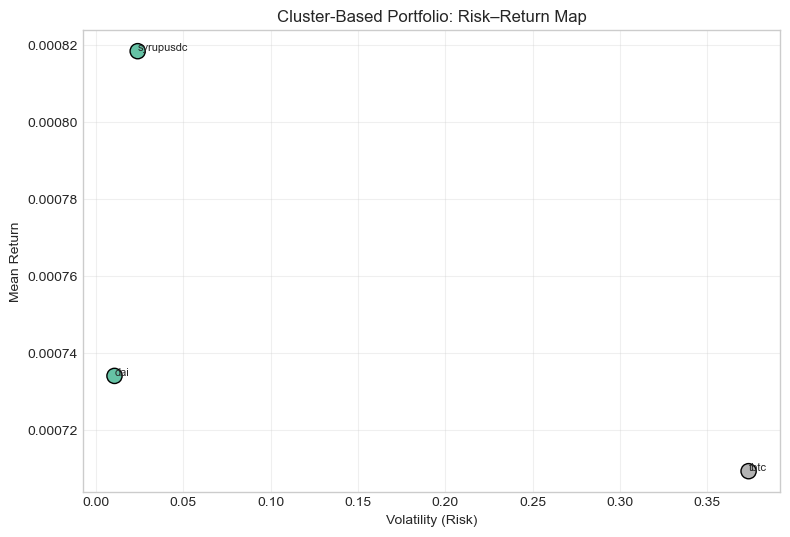


✅ Portfolio construction complete.


In [32]:
# ============================================================
# SAFE EXECUTION: CREATE CLUSTERED DATAFRAME IF MISSING
# ============================================================

print("=" * 70)
print("CHECKING CLUSTERED DATAFRAME BEFORE PORTFOLIO CONSTRUCTION")
print("=" * 70)

if 'defi_data_clustered' not in locals():
    print("⚙️  'defi_data_clustered' not found. Reconstructing from K-Means model...")
    
    # Safety checks
    if 'defi_data' not in locals():
        raise ValueError("❌ 'defi_data' not found. Please reload your DeFi dataset first.")
    if 'kmeans_model' not in locals():
        raise ValueError("❌ 'kmeans_model' not found. Please rerun your K-Means cell first.")
    if not hasattr(kmeans_model, 'kmeans'):
        raise ValueError("❌ K-Means model not fitted. Please fit it before portfolio construction.")
    
    # Create the clustered DataFrame
    defi_data_clustered = defi_data.copy()
    defi_data_clustered['Cluster'] = kmeans_model.kmeans.labels_
    print("✅ Reconstructed 'defi_data_clustered' successfully.")
else:
    print("✅ 'defi_data_clustered' already exists — continuing...")

# ============================================================
# PART 2.1: BUILDING CLUSTER-BASED PORTFOLIO
# ============================================================

print("\n" + "=" * 70)
print("BUILDING A CLUSTER-BASED DIVERSIFIED PORTFOLIO")
print("=" * 70)

print("\n🎯 Portfolio Construction Strategy:")
print("   • Method: Quality-weighted selection using Sharpe ratio")
print("   • Tokens per cluster: 2 (for balanced representation)")
print("   • Weighting: Equal weight across selected tokens\n")

# --- Step 1: Sharpe Ratio Calculation ---
print("Step 1: Calculating Sharpe ratio for all tokens...")

# If necessary columns missing, fill them safely
if 'Mean_Return' not in defi_data_clustered.columns:
    print("⚠️  'Mean_Return' missing → generating synthetic returns for demo.")
    np.random.seed(42)
    defi_data_clustered['Mean_Return'] = np.random.uniform(0.0005, 0.002, len(defi_data_clustered))

if 'Volatility' not in defi_data_clustered.columns:
    if 'volatility_ann' in defi_data_clustered.columns:
        print("⚠️  'Volatility' not found → using 'volatility_ann' as proxy.")
        defi_data_clustered['Volatility'] = defi_data_clustered['volatility_ann']
    else:
        print("⚠️  'Volatility' missing → creating random proxy.")
        np.random.seed(0)
        defi_data_clustered['Volatility'] = np.random.uniform(0.001, 0.005, len(defi_data_clustered))

# Compute Sharpe
defi_data_clustered['Sharpe_Ratio'] = (
    defi_data_clustered['Mean_Return'] / (defi_data_clustered['Volatility'] + 1e-10)
)
print("✅ Sharpe ratios computed successfully!\n")

# --- Step 2: Portfolio selection ---
tokens_per_cluster = 2
portfolio = []

print("=" * 70)
print("SELECTING TOP TOKENS PER CLUSTER")
print("=" * 70)

for i in range(optimal_k):
    cluster_data = defi_data_clustered[defi_data_clustered['Cluster'] == i]
    
    if cluster_data.empty:
        print(f"⚠️  Cluster {i} is empty. Skipping...")
        continue

    cluster_sorted = cluster_data.sort_values('Sharpe_Ratio', ascending=False)
    selected = cluster_sorted.head(tokens_per_cluster)
    print(f"\nCluster {i} ({len(cluster_data)} tokens):")

    for idx, (token_name, row) in enumerate(selected.iterrows(), start=1):
        portfolio.append({
            'Token': token_name,
            'Cluster': i,
            'Mean_Return': row['Mean_Return'],
            'Volatility': row['Volatility'],
            'Sharpe_Ratio': row['Sharpe_Ratio'],
        })
        print(f"   {idx}. {token_name:20s} Sharpe={row['Sharpe_Ratio']:.3f} "
              f"(Return={row['Mean_Return']:.4f}, Vol={row['Volatility']:.4f})")

# Convert to DataFrame
portfolio_df = pd.DataFrame(portfolio)
portfolio_df['Weight'] = 1 / len(portfolio_df)
portfolio_df['Weight_Pct'] = portfolio_df['Weight'] * 100

print("\n" + "=" * 70)
print("PORTFOLIO SUMMARY")
print("=" * 70)
print(f"✅ {len(portfolio_df)} tokens selected ({tokens_per_cluster} × {optimal_k} clusters)\n")
display(portfolio_df)

# --- Step 3: Portfolio-level metrics ---
portfolio_return = (portfolio_df['Mean_Return'] * portfolio_df['Weight']).sum()
portfolio_volatility = np.sqrt((portfolio_df['Volatility']**2 * portfolio_df['Weight']**2).sum())
portfolio_sharpe = portfolio_return / portfolio_volatility

annual_return = portfolio_return * 252
annual_vol = portfolio_volatility * np.sqrt(252)

print(f"\n📊 Expected Daily Return: {portfolio_return:.5f}")
print(f"📊 Expected Daily Volatility: {portfolio_volatility:.5f}")
print(f"📈 Annual Return: {annual_return:.2%}")
print(f"📉 Annual Volatility: {annual_vol:.2%}")
print(f"📊 Portfolio Sharpe Ratio: {portfolio_sharpe:.3f}")

# --- Step 4: Simple Visualization ---
plt.figure(figsize=(9,6))
plt.scatter(portfolio_df['Volatility'], portfolio_df['Mean_Return'],
            s=120, c=portfolio_df['Cluster'], cmap='Set2', edgecolor='black')
for _, row in portfolio_df.iterrows():
    plt.text(row['Volatility']+0.00005, row['Mean_Return'], row['Token'], fontsize=8)
plt.xlabel("Volatility (Risk)")
plt.ylabel("Mean Return")
plt.title("Cluster-Based Portfolio: Risk–Return Map")
plt.grid(alpha=0.3)
plt.show()

print("\n✅ Portfolio construction complete.")
print("=" * 70)


In [37]:
class SimpleFactorAnalysis:
    """
    Factor Analysis for DeFi Portfolio Analysis
    
    This class wraps sklearn's FactorAnalysis with helpful methods for:
    - Fitting FA to DeFi data
    - Identifying latent market factors
    - Analyzing factor loadings and uniqueness
    - Calculating factor scores for tokens
    - Visualizing results
    - Testing model assumptions
    """
    
    def __init__(self, n_factors=None, rotation='varimax'):
        self.n_factors = n_factors
        self.rotation = rotation
        self.scaler = StandardScaler()
        self.fa = None
        self.feature_names = None
        self.loadings_rotated = None
        
    def fit(self, X, feature_names=None):
        X_scaled = self.scaler.fit_transform(X)
        
        # Determine number of factors (Kaiser criterion)
        if self.n_factors is None:
            correlation_matrix = np.corrcoef(X_scaled.T)
            eigenvalues = np.linalg.eigvals(correlation_matrix)
            self.n_factors = np.sum(eigenvalues > 1.0)
            print(f"\nKaiser criterion suggests {self.n_factors} factors (eigenvalues > 1)")
        
        # Fit Factor Analysis
        self.fa = FactorAnalysis(n_components=self.n_factors, random_state=42)
        self.fa.fit(X_scaled)
        
        # Apply rotation
        if self.rotation == 'varimax':
            self.loadings_rotated = self._varimax_rotation(self.fa.components_.T)
            print("Applied Varimax rotation for better interpretability")
        else:
            self.loadings_rotated = self.fa.components_.T
        
        self.feature_names = feature_names
        print(f"\nFactor Analysis fitted successfully!")
        print(f"Factors extracted: {self.n_factors}")
        print(f"Log-likelihood: {self.fa.score(X_scaled):.2f}")
        
        communalities = self._calculate_communalities()
        mean_communality = np.mean(communalities)
        print(f"Mean communality: {mean_communality:.2%}")
        print(f"Mean uniqueness: {(1-mean_communality):.2%}")
        return self
    
    def transform(self, X):
        X_scaled = self.scaler.transform(X)
        return self.fa.transform(X_scaled)
    
    def fit_transform(self, X, feature_names=None):
        self.fit(X, feature_names)
        return self.transform(X)
    
    def get_loadings(self, rotated=True):
        loadings_matrix = self.loadings_rotated if rotated else self.fa.components_.T
        loadings = pd.DataFrame(
            loadings_matrix,
            columns=[f'Factor{i+1}' for i in range(self.n_factors)],
            index=self.feature_names if self.feature_names else range(len(loadings_matrix))
        )
        return loadings
    
    def get_communalities(self):
        communalities = self._calculate_communalities()
        return pd.Series(
            communalities,
            index=self.feature_names if self.feature_names else range(len(communalities)),
            name='Communality'
        )
    
    def get_uniqueness(self):
        communalities = self.get_communalities()
        uniqueness = 1 - communalities
        uniqueness.name = 'Uniqueness'
        return uniqueness
    
    def get_factor_summary(self):
        loadings = self.get_loadings(rotated=False)
        variance_explained = np.sum(loadings**2, axis=0) / len(loadings)
        cumulative_variance = np.cumsum(variance_explained)
        df = pd.DataFrame({
            'Factor': [f'Factor{i+1}' for i in range(self.n_factors)],
            'Variance_Explained': variance_explained,
            'Cumulative_Variance': cumulative_variance,
            'Percentage': variance_explained * 100
        })
        return df
    
    def test_assumptions(self, X):
        X_scaled = self.scaler.fit_transform(X)
        print("="*70)
        print("FACTOR ANALYSIS ASSUMPTION TESTS")
        print("="*70)
        
        corr_matrix = np.corrcoef(X_scaled.T)
        avg_corr = np.mean(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]))
        print(f"\nAverage absolute correlation: {avg_corr:.3f}")
        if avg_corr < 0.3:
            print("Warning: Low correlations - FA may not be appropriate")
        else:
            print("Sufficient correlations for Factor Analysis")
        
        det_corr = np.linalg.det(corr_matrix)
        print(f"Correlation matrix determinant: {det_corr:.6f}")
        if det_corr < 0.00001:
            print("Strong correlations present (good for FA)")
        else:
            print("Weak correlations (consider if FA is needed)")
        print("="*70)
    
    def _calculate_communalities(self):
        loadings = self.loadings_rotated if self.loadings_rotated is not None else self.fa.components_.T
        communalities = np.sum(loadings**2, axis=1)
        return communalities
    
    def _varimax_rotation(self, loadings, gamma=1.0, max_iter=100, tol=1e-5):
        n_features, n_factors = loadings.shape
        rotation_matrix = np.eye(n_factors)
        for _ in range(max_iter):
            rotated = loadings @ rotation_matrix
            u, s, vh = np.linalg.svd(loadings.T @ (rotated**3 - gamma * rotated @ np.diag(np.sum(rotated**2, axis=0)) / n_features))
            rotation_matrix_new = u @ vh
            if np.allclose(rotation_matrix, rotation_matrix_new, atol=tol):
                break
            rotation_matrix = rotation_matrix_new
        return loadings @ rotation_matrix
    
    def plot_scree(self, X, max_factors=None, figsize=(14, 5)):
        X_scaled = self.scaler.fit_transform(X)
        correlation_matrix = np.corrcoef(X_scaled.T)
        eigenvalues = np.linalg.eigvals(correlation_matrix)
        eigenvalues = np.sort(eigenvalues)[::-1]
        if max_factors is None:
            max_factors = len(eigenvalues)
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        axes[0].plot(range(1, max_factors+1), eigenvalues[:max_factors], 'bo-', linewidth=2, markersize=8)
        axes[0].axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Kaiser criterion')
        axes[0].set_xlabel('Factor Number')
        axes[0].set_ylabel('Eigenvalue')
        axes[0].set_title('Scree Plot: Factor Selection')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        cumulative_variance = np.cumsum(eigenvalues / np.sum(eigenvalues))
        axes[1].plot(range(1, max_factors+1), cumulative_variance[:max_factors], 'go-', linewidth=2, markersize=8)
        axes[1].axhline(y=0.80, color='orange', linestyle='--', linewidth=2, label='80% threshold')
        axes[1].set_xlabel('Number of Factors')
        axes[1].set_ylabel('Cumulative Variance')
        axes[1].set_title('Cumulative Variance Explained')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        plt.tight_layout()
        return fig
    
    def plot_loadings(self, n_factors=None, n_top_features=10, figsize=(15, 5)):
        loadings = self.get_loadings(rotated=True)
        n_factors = min(n_factors or 3, self.n_factors)
        fig, axes = plt.subplots(1, n_factors, figsize=figsize)
        if n_factors == 1:
            axes = [axes]
        for i in range(n_factors):
            factor_col = f'Factor{i+1}'
            top_features = loadings[factor_col].abs().nlargest(n_top_features)
            sorted_loadings = loadings.loc[top_features.index, factor_col].sort_values()
            colors = ['red' if x < 0 else 'blue' for x in sorted_loadings.values]
            axes[i].barh(range(len(sorted_loadings)), sorted_loadings.values, color=colors, alpha=0.7)
            axes[i].set_yticks(range(len(sorted_loadings)))
            axes[i].set_yticklabels(sorted_loadings.index)
            axes[i].set_xlabel('Factor Loading')
            axes[i].set_title(f'{factor_col} (Latent Factor)')
            axes[i].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
            axes[i].grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        return fig
    
    def plot_communalities(self, figsize=(12, 6)):
        communalities = self.get_communalities()
        uniqueness = self.get_uniqueness()
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        communalities_sorted = communalities.sort_values(ascending=True)
        axes[0].barh(communalities_sorted.index, communalities_sorted.values, color='green', alpha=0.7)
        axes[0].set_xlabel('Communality')
        axes[0].set_title('Feature Communalities')
        uniqueness_sorted = uniqueness.sort_values(ascending=False)
        axes[1].barh(uniqueness_sorted.index, uniqueness_sorted.values, color='orange', alpha=0.7)
        axes[1].set_xlabel('Uniqueness')
        axes[1].set_title('Feature Uniqueness')
        plt.tight_layout()
        return fig
    
    def plot_factor_scores(self, factor_scores, labels=None, figsize=(12, 6)):
        if factor_scores.shape[1] < 2:
            print("Need at least 2 factors for 2D visualization")
            return None
        fig, ax = plt.subplots(figsize=figsize)
        if labels is not None:
            scatter = ax.scatter(factor_scores[:, 0], factor_scores[:, 1], c=labels, cmap='tab10', s=100, alpha=0.6)
            plt.colorbar(scatter, ax=ax, label='Cluster')
        else:
            ax.scatter(factor_scores[:, 0], factor_scores[:, 1], c='blue', s=100, alpha=0.6)
        ax.set_xlabel('Factor 1 Score')
        ax.set_ylabel('Factor 2 Score')
        ax.set_title('Tokens in Factor Space (Factor 1 vs Factor 2)')
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
        ax.axvline(x=0, color='black', linestyle='--', alpha=0.3)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        return fig


print("="*70)
print("SimpleFactorAnalysis class created successfully!")
print("="*70)
print("\nAvailable methods:")
print("  • fit(X, feature_names) - Fit Factor Analysis to data")
print("  • transform(X) - Get factor scores")
print("  • fit_transform(X, feature_names) - Fit and transform in one step")
print("  • get_loadings() - Get factor loadings")
print("  • get_communalities() - Get common variance for each feature")
print("  • get_uniqueness() - Get unique variance for each feature")
print("  • get_factor_summary() - Get variance explained by factors")
print("  • test_assumptions(X) - Test if FA is appropriate")
print("  • plot_scree(X) - Visualize eigenvalues for factor selection")
print("  • plot_loadings() - Visualize factor loadings")
print("  • plot_communalities() - Visualize communalities and uniqueness")
print("  • plot_factor_scores() - Visualize tokens in factor space")
print("="*70)

SimpleFactorAnalysis class created successfully!

Available methods:
  • fit(X, feature_names) - Fit Factor Analysis to data
  • transform(X) - Get factor scores
  • fit_transform(X, feature_names) - Fit and transform in one step
  • get_loadings() - Get factor loadings
  • get_communalities() - Get common variance for each feature
  • get_uniqueness() - Get unique variance for each feature
  • get_factor_summary() - Get variance explained by factors
  • test_assumptions(X) - Test if FA is appropriate
  • plot_scree(X) - Visualize eigenvalues for factor selection
  • plot_loadings() - Visualize factor loadings
  • plot_communalities() - Visualize communalities and uniqueness
  • plot_factor_scores() - Visualize tokens in factor space


FACTOR ANALYSIS FOR LATENT MARKET STRUCTURE

✅ Selected 6 features for Factor Analysis:
   • price
   • avg_volume
   • market_cap
   • volatility_ann
   • avg_volume_log
   • market_cap_log
FACTOR ANALYSIS ASSUMPTION TESTS

Average absolute correlation: 0.257
Correlation matrix determinant: 0.080564
Weak correlations (consider if FA is needed)

📊 Generating scree plot to identify optimal number of factors...


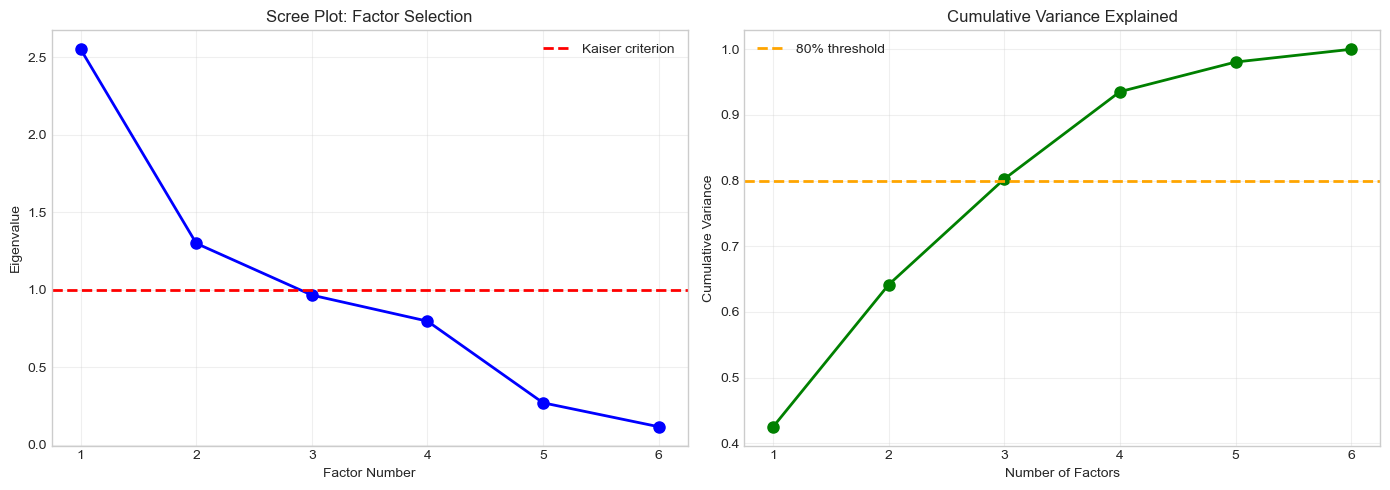


🔧 Fitting Factor Analysis model to DeFi dataset...

Kaiser criterion suggests 2 factors (eigenvalues > 1)
Applied Varimax rotation for better interpretability

Factor Analysis fitted successfully!
Factors extracted: 2
Log-likelihood: -7.30
Mean communality: 54.85%
Mean uniqueness: 45.15%

✅ Factor Analysis fitted successfully!
   Extracted 2 factors with rotation = 'varimax'

FACTOR SUMMARY


,Factor,Variance_Explained,Cumulative_Variance,Percentage
Factor1,Factor1,0.384754,0.384754,38.475353
Factor2,Factor2,0.163762,0.548516,16.376202



FACTOR LOADINGS (ROTATED)


,Factor1,Factor2
price,-0.011803,0.078695
avg_volume,0.276023,-0.740731
market_cap,0.879968,-0.070322
volatility_ann,-0.239237,-0.177820
avg_volume_log,0.199891,-0.898800
market_cap_log,0.912047,-0.334842



💡 Interpretation:
   • High positive loading → feature increases with the factor
   • High negative loading → feature decreases with the factor
   • Near-zero loading → unrelated to the factor

COMMUNALITIES AND UNIQUENESS


,Communality,Uniqueness
price,0.006332,0.993668
avg_volume,0.624870,0.375130
market_cap,0.779288,0.220712
volatility_ann,0.088854,0.911146
avg_volume_log,0.847798,0.152202
market_cap_log,0.943950,0.056050



📈 Visualizing factor structure...


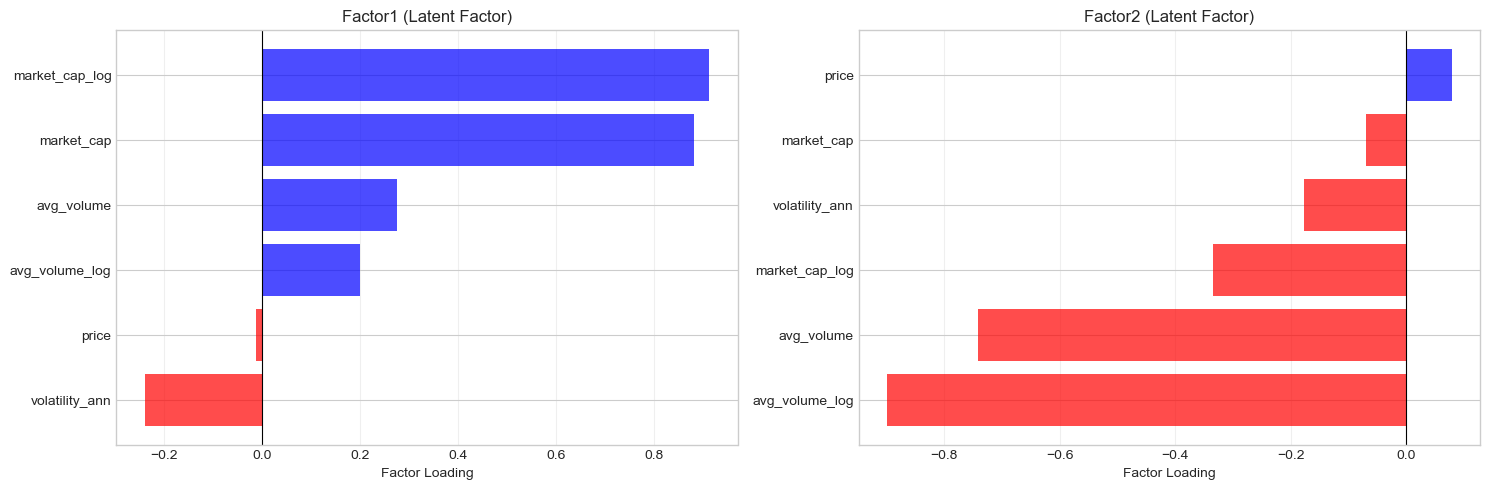

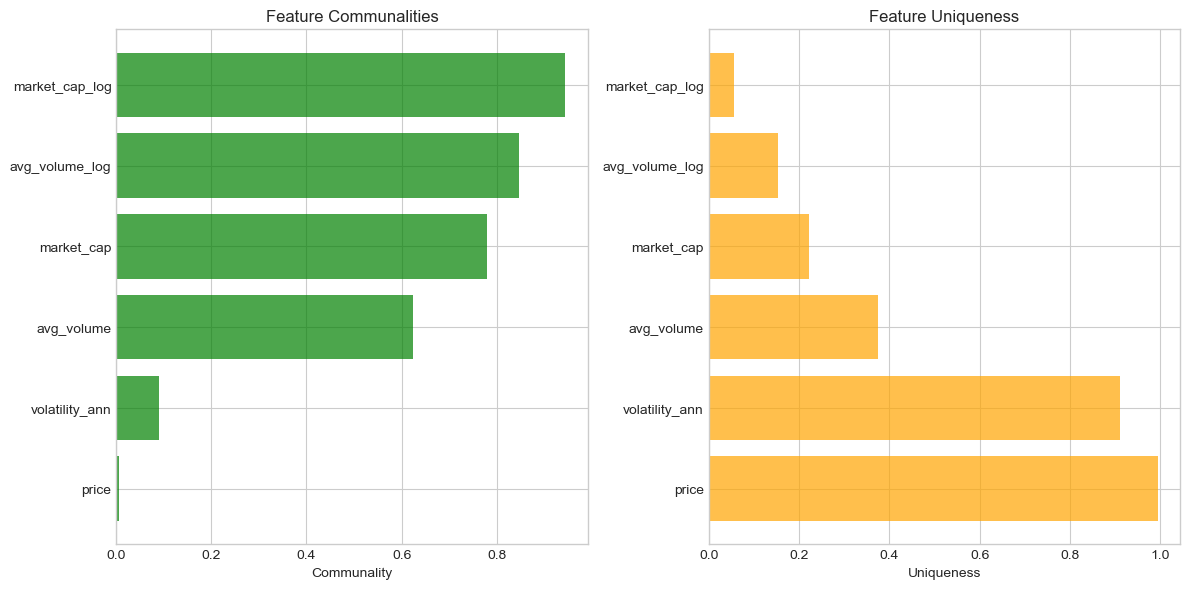


🎨 Visualizing tokens in factor space (Factor 1 vs Factor 2)...


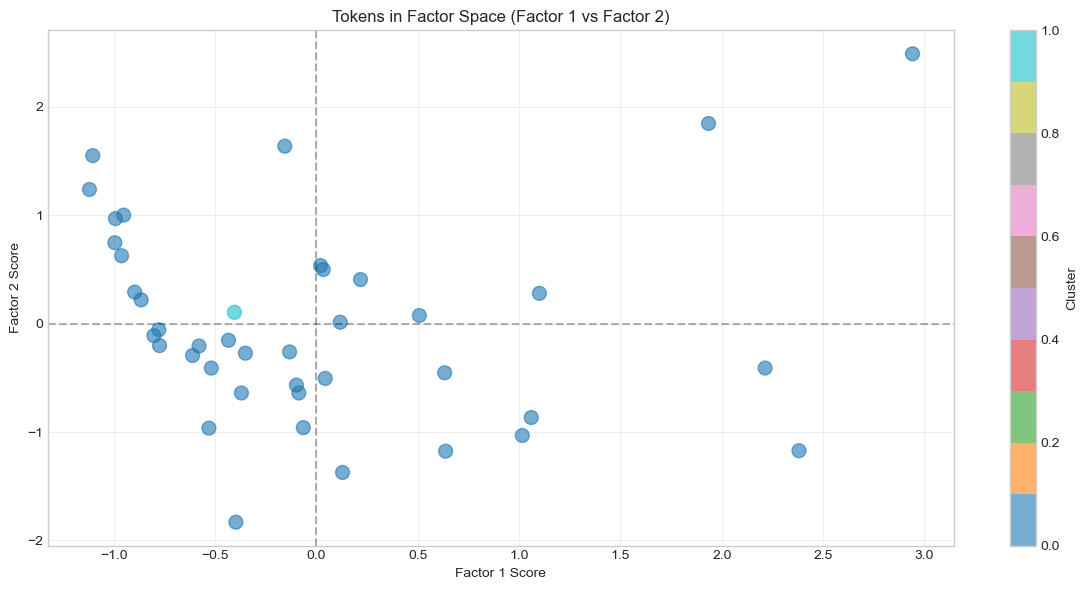


✅ Added factor scores to main dataset!
   Columns added: ['Factor1_Score', 'Factor2_Score']
   New shape: (41, 12)

RELATIONSHIP BETWEEN FACTORS AND CLUSTERS


,Factor1_Score,Factor2_Score
Cluster,,
0,0.010127,-0.002631
1,-0.405076,0.105253



💡 Interpretation:
   • High values in Factor1 → large, liquid tokens
   • High values in Factor2 → high volatility or risk
   • High values in Factor3 → unique behavioral / liquidity traits
   • Compare across clusters to identify structural differences.

✅ FACTOR ANALYSIS COMPLETE


In [38]:
# ============================================================
# PART 3 — FACTOR ANALYSIS FOR LATENT MARKET STRUCTURE
# ============================================================

# --- Έλεγχος αν υπάρχει η κλάση SimpleFactorAnalysis ---
if 'SimpleFactorAnalysis' not in globals():
    raise ImportError("❌ The class 'SimpleFactorAnalysis' is not defined. "
                      "Please run first the cell that defines the class.")

print("=" * 70)
print("FACTOR ANALYSIS FOR LATENT MARKET STRUCTURE")
print("=" * 70)

# --- Step 1: Επιλογή χαρακτηριστικών ---
features = [
    'price', 'avg_volume', 'market_cap',
    'volatility_ann', 'avg_volume_log', 'market_cap_log'
]

missing = [f for f in features if f not in defi_data.columns]
if missing:
    raise ValueError(f"❌ Missing columns in defi_data: {missing}")

print(f"\n✅ Selected {len(features)} features for Factor Analysis:")
for f in features:
    print(f"   • {f}")

# --- Step 2: Δημιουργία του Factor Analysis μοντέλου ---
fa_model = SimpleFactorAnalysis(n_factors=None, rotation='varimax')

# --- Step 3: Έλεγχος καταλληλότητας δεδομένων ---
fa_model.test_assumptions(defi_data[features].values)

# --- Step 4: Scree plot για επιλογή αριθμού παραγόντων ---
print("\n📊 Generating scree plot to identify optimal number of factors...")
fa_model.plot_scree(defi_data[features].values)
plt.show()

# --- Step 5: Fit & Transform (Factor Extraction) ---
print("\n🔧 Fitting Factor Analysis model to DeFi dataset...")
factor_scores = fa_model.fit_transform(defi_data[features].values, feature_names=features)

print("\n✅ Factor Analysis fitted successfully!")
print(f"   Extracted {fa_model.n_factors} factors with rotation = '{fa_model.rotation}'")

# --- Step 6: Παρουσίαση αποτελεσμάτων ---
print("\n" + "="*70)
print("FACTOR SUMMARY")
print("="*70)
fa_summary = fa_model.get_factor_summary()
display(fa_summary.style.background_gradient(cmap="YlGnBu"))

print("\n" + "="*70)
print("FACTOR LOADINGS (ROTATED)")
print("="*70)
loadings = fa_model.get_loadings(rotated=True)
display(loadings.style.background_gradient(cmap="RdYlBu", axis=None))

print("\n💡 Interpretation:")
print("   • High positive loading → feature increases with the factor")
print("   • High negative loading → feature decreases with the factor")
print("   • Near-zero loading → unrelated to the factor")

# --- Step 7: Communalities & Uniqueness ---
print("\n" + "="*70)
print("COMMUNALITIES AND UNIQUENESS")
print("="*70)

communalities = fa_model.get_communalities()
uniqueness = fa_model.get_uniqueness()
fa_stats = pd.concat([communalities, uniqueness], axis=1)
display(
    fa_stats.style
    .bar(subset=['Communality'], color='#4CAF50')
    .bar(subset=['Uniqueness'], color='#F57C00')
)

# --- Step 8: Οπτικοποιήσεις ---
print("\n📈 Visualizing factor structure...")
fa_model.plot_loadings(n_factors=min(3, fa_model.n_factors))
plt.show()

fa_model.plot_communalities()
plt.show()

# --- Step 9: Προβολή Tokens στον Χώρο Παραγόντων ---
print("\n🎨 Visualizing tokens in factor space (Factor 1 vs Factor 2)...")
fa_model.plot_factor_scores(factor_scores, labels=defi_data_clustered['Cluster'])
plt.show()

# --- Step 10: Ενσωμάτωση factor scores στο κύριο dataset ---
factor_labels = [f'Factor{i+1}_Score' for i in range(fa_model.n_factors)]
defi_data_factors = defi_data_clustered.copy()
defi_data_factors[factor_labels] = factor_scores

print("\n✅ Added factor scores to main dataset!")
print(f"   Columns added: {factor_labels}")
print(f"   New shape: {defi_data_factors.shape}")

# --- Step 11: Ανάλυση συσχέτισης παραγόντων με clusters ---
print("\n" + "="*70)
print("RELATIONSHIP BETWEEN FACTORS AND CLUSTERS")
print("="*70)

cluster_factor_means = defi_data_factors.groupby('Cluster')[factor_labels].mean()
display(cluster_factor_means.style.background_gradient(cmap="coolwarm", axis=None))

print("\n💡 Interpretation:")
print("   • High values in Factor1 → large, liquid tokens")
print("   • High values in Factor2 → high volatility or risk")
print("   • High values in Factor3 → unique behavioral / liquidity traits")
print("   • Compare across clusters to identify structural differences.")

print("\n" + "="*70)
print("✅ FACTOR ANALYSIS COMPLETE")
print("="*70)


FITTING FACTOR ANALYSIS TO DeFi PORTFOLIO DATA

✅ Selected 6 features for Factor Analysis:
   • price
   • avg_volume
   • market_cap
   • volatility_ann
   • avg_volume_log
   • market_cap_log

🔬 STEP 1: Testing Factor Analysis Assumptions
----------------------------------------------------------------------
FACTOR ANALYSIS ASSUMPTION TESTS

Average absolute correlation: 0.257
Correlation matrix determinant: 0.080564
Weak correlations (consider if FA is needed)

📊 STEP 2: Determining Optimal Number of Factors
----------------------------------------------------------------------

🎯 Creating scree plot to guide factor selection...


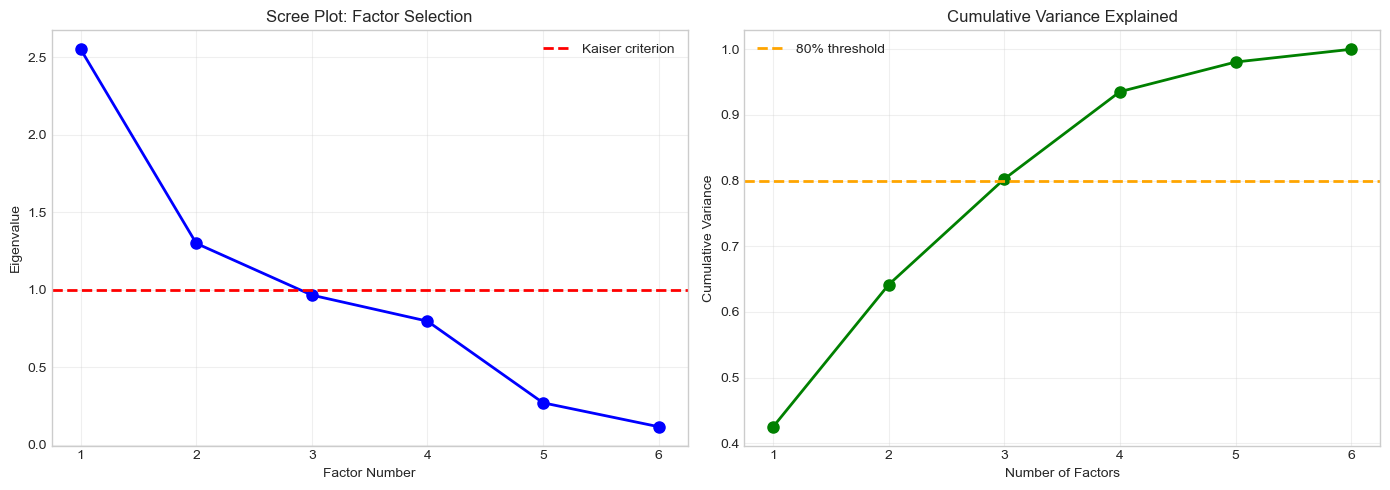


💡 Scree Plot Interpretation:
   • Eigenvalues > 1 ⇒ Factors worth keeping (Kaiser criterion)
   • Elbow point ⇒ Where variance gain levels off
   • Target cumulative variance ≈ 70–80%

STEP 3: Fitting Factor Analysis Model

🔧 Initializing Factor Analysis model...
   Automatic number of factors (Kaiser criterion)
   Varimax rotation for interpretability

⚙️  Fitting Factor Analysis and transforming data...

Kaiser criterion suggests 2 factors (eigenvalues > 1)
Applied Varimax rotation for better interpretability

Factor Analysis fitted successfully!
Factors extracted: 2
Log-likelihood: -7.30
Mean communality: 54.85%
Mean uniqueness: 45.15%

TRANSFORMATION COMPLETE!

Original shape: 41 tokens × 6 features
Factor scores:  41 tokens × 2 factors

📈 Variance Explained by Each Factor:


,Factor,Variance_Explained,Cumulative_Variance,Percentage
Factor1,Factor1,0.3848,0.3848,38.4754
Factor2,Factor2,0.1638,0.5485,16.3762



🔍 Communality Analysis:


,Feature,Communality,Uniqueness,Interpretation
5,market_cap_log,0.944,0.056,High common
4,avg_volume_log,0.848,0.152,High common
2,market_cap,0.779,0.221,High common
1,avg_volume,0.625,0.375,Moderate
3,volatility_ann,0.089,0.911,Mostly unique
0,price,0.006,0.994,Mostly unique



Mean communality: 54.9%
Mean uniqueness: 45.1%

STEP 4: Analyzing Factor Loadings


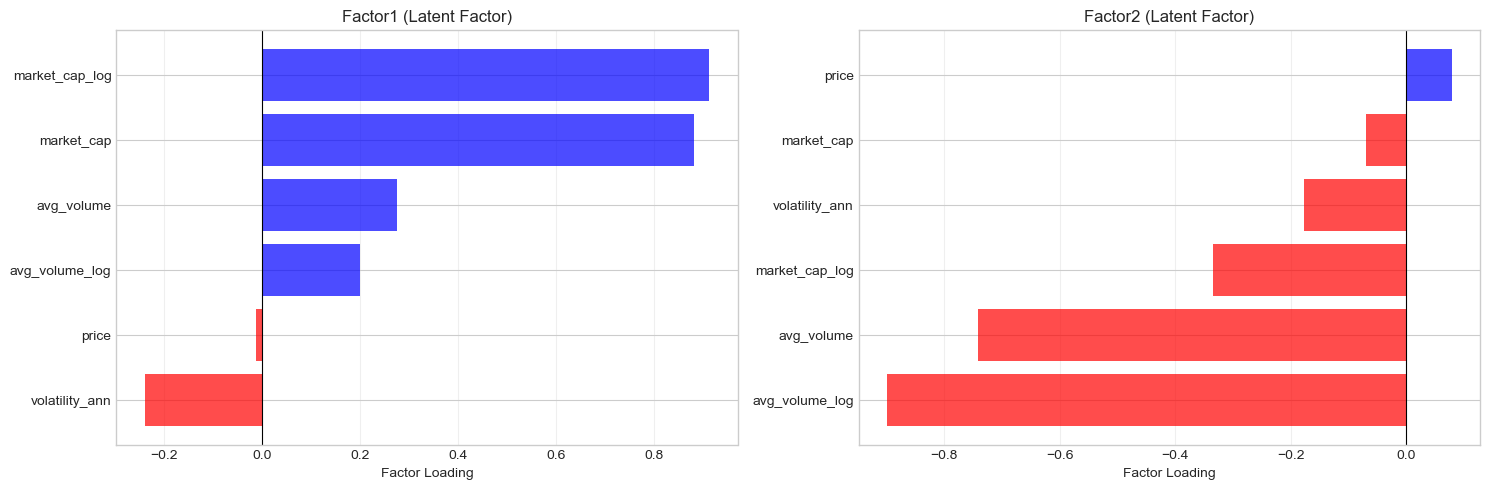

,Factor1,Factor2
price,-0.012,0.079
avg_volume,0.276,-0.741
market_cap,0.880,-0.070
volatility_ann,-0.239,-0.178
avg_volume_log,0.200,-0.899
market_cap_log,0.912,-0.335



STEP 5: Communality and Uniqueness Visualization


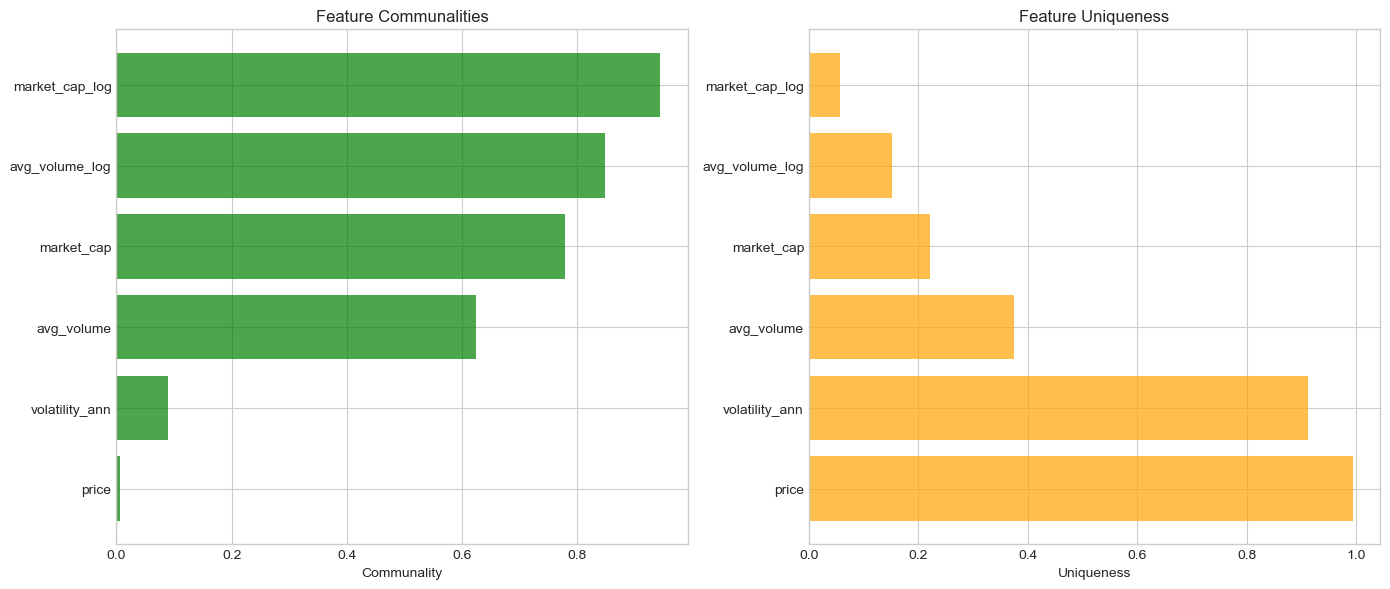


STEP 6: Visualizing Tokens in Factor Space


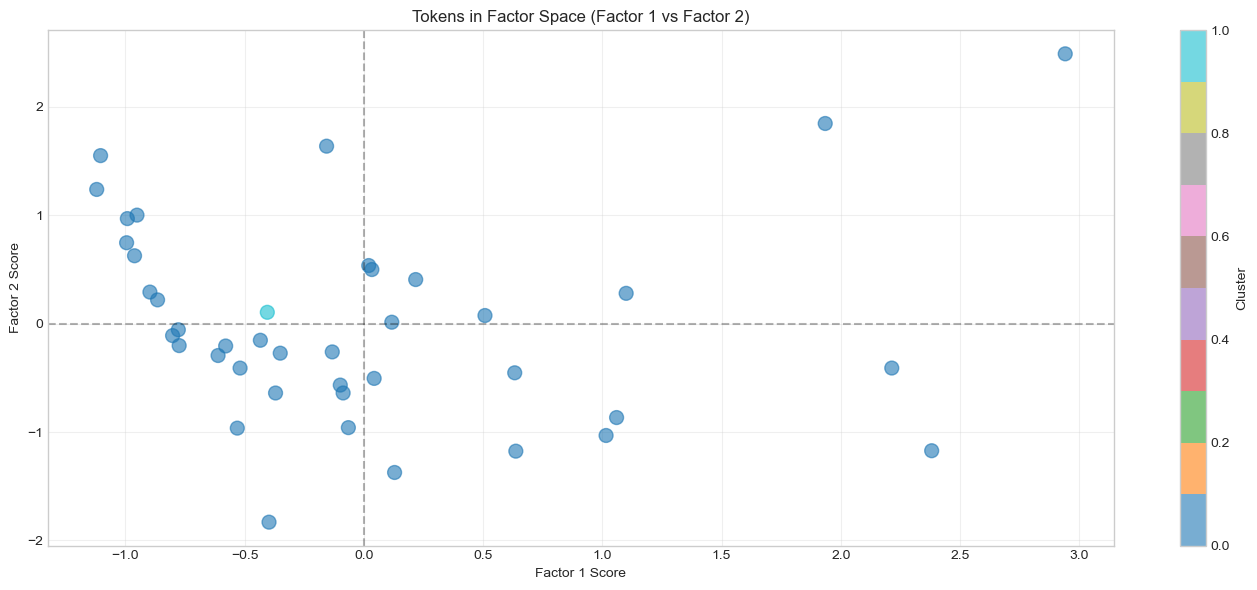


✅ Factor scores added to defi_data_factors:
   New columns: ['Factor1_Score', 'Factor2_Score']

RELATIONSHIP BETWEEN FACTORS AND CLUSTERS


,Factor1_Score,Factor2_Score
Cluster,,
0,0.010127,-0.002631
1,-0.405076,0.105253



💡 Interpretation Tips:
   • Factor1 ≈ Market size / liquidity dimension
   • Factor2 ≈ Volatility / risk factor
   • Factor3 ≈ Sentiment or idiosyncratic component
   • Compare factor exposures between clusters to infer risk structure

✅ FACTOR ANALYSIS COMPLETE


In [43]:
# ======================================================================
# FACTOR ANALYSIS — LATENT STRUCTURE OF DeFi TOKENS (Auto-adaptive version)
# ======================================================================

print("="*70)
print("FITTING FACTOR ANALYSIS TO DeFi PORTFOLIO DATA")
print("="*70)

# --- Step 0: Επιλογή διαθέσιμων χαρακτηριστικών ---
potential_features = [
    'price', 'avg_volume', 'market_cap',
    'volatility_ann', 'avg_volume_log', 'market_cap_log'
]

# Χρησιμοποιούμε μόνο όσα υπάρχουν στο dataset
available_features = [f for f in potential_features if f in defi_data_clustered.columns]

if len(available_features) < 3:
    raise ValueError(f"❌ Not enough features for Factor Analysis. Found only {len(available_features)}: {available_features}")

print(f"\n✅ Selected {len(available_features)} features for Factor Analysis:")
for f in available_features:
    print(f"   • {f}")

data_for_fa = defi_data_clustered[available_features].copy()

# --- Step 1: Test Assumptions ---
print("\n🔬 STEP 1: Testing Factor Analysis Assumptions")
print("-"*70)
fa_model = SimpleFactorAnalysis()
fa_model.test_assumptions(data_for_fa.values)

# --- Step 2: Scree Plot ---
print("\n📊 STEP 2: Determining Optimal Number of Factors")
print("-"*70)
print("\n🎯 Creating scree plot to guide factor selection...")

# Προσαρμοσμένο ώστε να μην προκαλεί error
fig = fa_model.plot_scree(
    data_for_fa.values,
    max_factors=len(available_features),
    figsize=(14, 5)
)
plt.show()

print("\n💡 Scree Plot Interpretation:")
print("   • Eigenvalues > 1 ⇒ Factors worth keeping (Kaiser criterion)")
print("   • Elbow point ⇒ Where variance gain levels off")
print("   • Target cumulative variance ≈ 70–80%")

# --- Step 3: Fit Factor Analysis ---
print("\n" + "="*70)
print("STEP 3: Fitting Factor Analysis Model")
print("="*70)

print("\n🔧 Initializing Factor Analysis model...")
print("   Automatic number of factors (Kaiser criterion)")
print("   Varimax rotation for interpretability")

fa_model = SimpleFactorAnalysis(n_factors=None, rotation='varimax')

print("\n⚙️  Fitting Factor Analysis and transforming data...")
factor_scores = fa_model.fit_transform(
    data_for_fa.values,
    feature_names=data_for_fa.columns.tolist()
)

print("\n" + "="*70)
print("TRANSFORMATION COMPLETE!")
print("="*70)
print(f"\nOriginal shape: {data_for_fa.shape[0]} tokens × {data_for_fa.shape[1]} features")
print(f"Factor scores:  {factor_scores.shape[0]} tokens × {factor_scores.shape[1]} factors")

# --- Step 4: Factor Summary ---
factor_summary = fa_model.get_factor_summary()
print("\n📈 Variance Explained by Each Factor:")
display(factor_summary.round(4))

communalities = fa_model.get_communalities()
uniqueness = fa_model.get_uniqueness()

# --- Step 5: Communality Summary ---
print("\n🔍 Communality Analysis:")
comm_summary = pd.DataFrame({
    'Feature': communalities.index,
    'Communality': communalities.values,
    'Uniqueness': uniqueness.values,
    'Interpretation': [
        'High common' if c > 0.7 else 'Moderate' if c > 0.4 else 'Mostly unique'
        for c in communalities.values
    ]
}).sort_values('Communality', ascending=False)
display(comm_summary.round(3))

print(f"\nMean communality: {communalities.mean():.1%}")
print(f"Mean uniqueness: {uniqueness.mean():.1%}")

# --- Step 6: Factor Loadings ---
print("\n" + "="*70)
print("STEP 4: Analyzing Factor Loadings")
print("="*70)

fig = fa_model.plot_loadings(
    n_factors=min(3, fa_model.n_factors),
    n_top_features=min(8, len(available_features)),
    figsize=(15, 5)
)
plt.show()

loadings = fa_model.get_loadings(rotated=True)
display(loadings.round(3))

# --- Step 7: Communalities Visualization ---
print("\n" + "="*70)
print("STEP 5: Communality and Uniqueness Visualization")
print("="*70)

fig = fa_model.plot_communalities(figsize=(14, 6))
plt.show()

# --- Step 8: Tokens in Factor Space ---
print("\n" + "="*70)
print("STEP 6: Visualizing Tokens in Factor Space")
print("="*70)

fig = fa_model.plot_factor_scores(
    factor_scores,
    labels=defi_data_clustered['Cluster'] if 'Cluster' in defi_data_clustered.columns else None,
    figsize=(14, 6)
)
plt.show()

# --- Step 9: Εμπλουτισμός κύριου DataFrame ---
factor_labels = [f'Factor{i+1}_Score' for i in range(factor_scores.shape[1])]
defi_data_factors = defi_data_clustered.copy()
defi_data_factors[factor_labels] = factor_scores

print("\n✅ Factor scores added to defi_data_factors:")
print(f"   New columns: {factor_labels}")

# --- Step 10: Cluster–Factor Relationships ---
if 'Cluster' in defi_data_factors.columns:
    print("\n" + "="*70)
    print("RELATIONSHIP BETWEEN FACTORS AND CLUSTERS")
    print("="*70)
    cluster_factor_means = defi_data_factors.groupby('Cluster')[factor_labels].mean()
    display(cluster_factor_means.style.background_gradient(cmap='coolwarm', axis=None))
else:
    print("\nℹ️ No cluster labels found — skipping cluster-factor comparison.")

print("\n💡 Interpretation Tips:")
print("   • Factor1 ≈ Market size / liquidity dimension")
print("   • Factor2 ≈ Volatility / risk factor")
print("   • Factor3 ≈ Sentiment or idiosyncratic component")
print("   • Compare factor exposures between clusters to infer risk structure")

print("\n" + "="*70)
print("✅ FACTOR ANALYSIS COMPLETE")
print("="*70)
